# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder("./" + data_dir, transform)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 16
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

IndexError: index 16 is out of bounds for dimension 0 with size 16

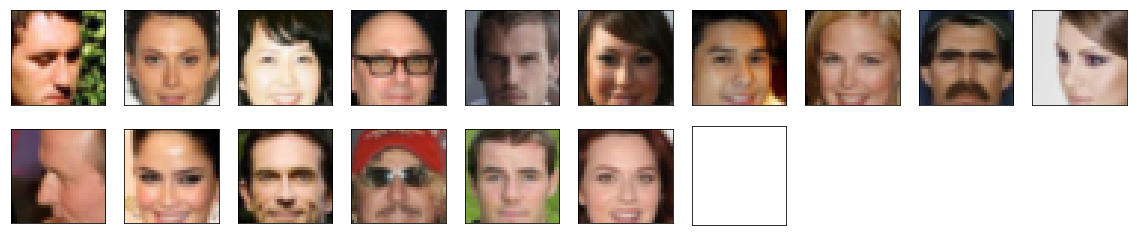

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function
# From Udacity Notebook: CycleGAN, Lesson 4-3, Implementing a CycleGAN
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)        
        return x   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
# From Udacity Notebook: DCGAN_Exercise, Lesson 2-10, Deep Convolutional GANs
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # Append deconv layer
    layers.append(deconv_layer)
    
    if batch_norm:
        # Append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function

        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        # Takes input and converts it into a fully connected layer capable of being reshaped
        # into a transpose convolutional layer of 128x4x4
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        # Input = 128x4x4, Output = 64x8x8
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2)
        # Input = 64x8x8, Output = 32x16x16
        self.t_conv2 = deconv(conv_dim*2, conv_dim)
        # Input = 32x16x16, Output = 3x32x32
        self.t_conv3 = deconv(conv_dim, 3, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, height, width)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        # Apply a normal distribution to the weights and let bias = 0.
        m.weight.data.normal_(std=0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    # Real labels should be labeled 1.
    labels = torch.ones(batch_size)
    # Move labels to GPU. If available     
    if train_on_gpu:
        labels = labels.cuda()
        
    #Binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    # Fake labels should be labeled 0
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.000003
beta1=0.1
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
from workspace_utils import keep_awake
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
for i in keep_awake(range(1)):
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.3463 | g_loss: 0.8389
Epoch [    1/  100] | d_loss: 1.1972 | g_loss: 0.8053
Epoch [    1/  100] | d_loss: 1.1509 | g_loss: 0.7508
Epoch [    1/  100] | d_loss: 1.0931 | g_loss: 0.8381
Epoch [    1/  100] | d_loss: 0.9495 | g_loss: 0.8104
Epoch [    1/  100] | d_loss: 0.8363 | g_loss: 0.8664
Epoch [    1/  100] | d_loss: 0.8606 | g_loss: 0.9373
Epoch [    1/  100] | d_loss: 0.8215 | g_loss: 0.9371
Epoch [    1/  100] | d_loss: 0.8580 | g_loss: 0.9492
Epoch [    1/  100] | d_loss: 0.8019 | g_loss: 0.9932
Epoch [    1/  100] | d_loss: 0.7192 | g_loss: 1.0226
Epoch [    1/  100] | d_loss: 0.7300 | g_loss: 1.0254
Epoch [    1/  100] | d_loss: 0.6664 | g_loss: 1.0147
Epoch [    1/  100] | d_loss: 0.6985 | g_loss: 1.0789
Epoch [    1/  100] | d_loss: 0.6523 | g_loss: 1.0117
Epoch [    1/  100] | d_loss: 0.6637 | g_loss: 1.0184
Epoch [    1/  100] | d_loss: 0.6740 | g_loss: 1.1255
Epoch [    1/  100] | d_loss: 0.5988 | g_loss: 1.2265
Epoch [    1/  100] | d_loss

Epoch [    2/  100] | d_loss: 0.0721 | g_loss: 4.1316
Epoch [    2/  100] | d_loss: 0.0535 | g_loss: 4.0068
Epoch [    2/  100] | d_loss: 0.0640 | g_loss: 3.7471
Epoch [    2/  100] | d_loss: 0.0397 | g_loss: 3.3521
Epoch [    2/  100] | d_loss: 0.0448 | g_loss: 3.6647
Epoch [    2/  100] | d_loss: 0.0721 | g_loss: 3.4035
Epoch [    2/  100] | d_loss: 0.0588 | g_loss: 3.6954
Epoch [    2/  100] | d_loss: 0.0737 | g_loss: 3.9611
Epoch [    2/  100] | d_loss: 0.0942 | g_loss: 3.5590
Epoch [    2/  100] | d_loss: 0.0563 | g_loss: 3.5890
Epoch [    2/  100] | d_loss: 0.0816 | g_loss: 3.5653
Epoch [    2/  100] | d_loss: 0.0590 | g_loss: 3.6148
Epoch [    2/  100] | d_loss: 0.0462 | g_loss: 4.0035
Epoch [    2/  100] | d_loss: 0.0570 | g_loss: 3.4097
Epoch [    2/  100] | d_loss: 0.0877 | g_loss: 3.5735
Epoch [    2/  100] | d_loss: 0.0707 | g_loss: 3.9566
Epoch [    2/  100] | d_loss: 0.1480 | g_loss: 3.4722
Epoch [    2/  100] | d_loss: 0.0967 | g_loss: 3.6639
Epoch [    2/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.2032 | g_loss: 2.9309
Epoch [    3/  100] | d_loss: 0.1070 | g_loss: 3.1059
Epoch [    3/  100] | d_loss: 0.1157 | g_loss: 3.4893
Epoch [    3/  100] | d_loss: 0.2186 | g_loss: 3.3915
Epoch [    3/  100] | d_loss: 0.1054 | g_loss: 2.5357
Epoch [    3/  100] | d_loss: 0.1762 | g_loss: 3.1009
Epoch [    3/  100] | d_loss: 0.1282 | g_loss: 2.8469
Epoch [    3/  100] | d_loss: 0.0829 | g_loss: 3.0296
Epoch [    3/  100] | d_loss: 0.1540 | g_loss: 3.0097
Epoch [    3/  100] | d_loss: 0.1187 | g_loss: 3.2098
Epoch [    3/  100] | d_loss: 0.1602 | g_loss: 2.8343
Epoch [    3/  100] | d_loss: 0.0990 | g_loss: 2.9183
Epoch [    3/  100] | d_loss: 0.1125 | g_loss: 3.2657
Epoch [    3/  100] | d_loss: 0.1599 | g_loss: 3.5503
Epoch [    3/  100] | d_loss: 0.1541 | g_loss: 3.0993
Epoch [    3/  100] | d_loss: 0.2137 | g_loss: 3.1941
Epoch [    3/  100] | d_loss: 0.1070 | g_loss: 3.6340
Epoch [    3/  100] | d_loss: 0.0984 | g_loss: 3.2665
Epoch [    3/  100] | d_loss

Epoch [    5/  100] | d_loss: 0.4173 | g_loss: 1.6794
Epoch [    5/  100] | d_loss: 0.3578 | g_loss: 2.0443
Epoch [    5/  100] | d_loss: 0.2585 | g_loss: 2.4736
Epoch [    5/  100] | d_loss: 0.4434 | g_loss: 1.7777
Epoch [    5/  100] | d_loss: 0.3623 | g_loss: 1.7159
Epoch [    5/  100] | d_loss: 0.3718 | g_loss: 2.0462
Epoch [    5/  100] | d_loss: 0.3941 | g_loss: 2.2537
Epoch [    5/  100] | d_loss: 0.2443 | g_loss: 2.4426
Epoch [    5/  100] | d_loss: 0.3654 | g_loss: 2.2791
Epoch [    5/  100] | d_loss: 0.1704 | g_loss: 1.8674
Epoch [    5/  100] | d_loss: 0.2826 | g_loss: 2.1594
Epoch [    5/  100] | d_loss: 0.4364 | g_loss: 2.0595
Epoch [    5/  100] | d_loss: 0.3247 | g_loss: 2.3025
Epoch [    5/  100] | d_loss: 0.4653 | g_loss: 1.9070
Epoch [    5/  100] | d_loss: 0.4427 | g_loss: 2.1538
Epoch [    5/  100] | d_loss: 0.3185 | g_loss: 2.1898
Epoch [    5/  100] | d_loss: 0.6195 | g_loss: 1.6899
Epoch [    5/  100] | d_loss: 0.3284 | g_loss: 1.7740
Epoch [    5/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.4371 | g_loss: 1.4478
Epoch [    6/  100] | d_loss: 0.8439 | g_loss: 1.3828
Epoch [    6/  100] | d_loss: 0.8278 | g_loss: 1.4101
Epoch [    6/  100] | d_loss: 0.5501 | g_loss: 1.4340
Epoch [    6/  100] | d_loss: 0.9297 | g_loss: 1.2098
Epoch [    6/  100] | d_loss: 0.5797 | g_loss: 1.3312
Epoch [    6/  100] | d_loss: 0.6037 | g_loss: 1.1421
Epoch [    6/  100] | d_loss: 0.7018 | g_loss: 1.4164
Epoch [    6/  100] | d_loss: 0.5708 | g_loss: 1.2610
Epoch [    6/  100] | d_loss: 0.4747 | g_loss: 1.3767
Epoch [    6/  100] | d_loss: 0.6615 | g_loss: 1.4020
Epoch [    6/  100] | d_loss: 0.6101 | g_loss: 1.2872
Epoch [    6/  100] | d_loss: 0.5587 | g_loss: 1.6387
Epoch [    6/  100] | d_loss: 0.7049 | g_loss: 1.4067
Epoch [    6/  100] | d_loss: 0.5900 | g_loss: 1.4592
Epoch [    6/  100] | d_loss: 0.6142 | g_loss: 1.3294
Epoch [    6/  100] | d_loss: 0.9162 | g_loss: 1.6154
Epoch [    6/  100] | d_loss: 0.9525 | g_loss: 1.2232
Epoch [    6/  100] | d_loss

Epoch [    7/  100] | d_loss: 0.6181 | g_loss: 1.5001
Epoch [    7/  100] | d_loss: 0.8470 | g_loss: 1.6364
Epoch [    7/  100] | d_loss: 0.7661 | g_loss: 1.4414
Epoch [    7/  100] | d_loss: 0.7613 | g_loss: 1.1958
Epoch [    7/  100] | d_loss: 0.6389 | g_loss: 1.2095
Epoch [    7/  100] | d_loss: 0.9785 | g_loss: 1.4399
Epoch [    7/  100] | d_loss: 0.5771 | g_loss: 1.5945
Epoch [    7/  100] | d_loss: 0.6356 | g_loss: 1.5066
Epoch [    7/  100] | d_loss: 0.6481 | g_loss: 1.4290
Epoch [    7/  100] | d_loss: 0.9995 | g_loss: 1.2299
Epoch [    7/  100] | d_loss: 0.8024 | g_loss: 1.1565
Epoch [    7/  100] | d_loss: 0.5614 | g_loss: 1.3606
Epoch [    7/  100] | d_loss: 0.8653 | g_loss: 1.3026
Epoch [    7/  100] | d_loss: 0.7535 | g_loss: 1.1607
Epoch [    7/  100] | d_loss: 0.5272 | g_loss: 1.3724
Epoch [    7/  100] | d_loss: 0.8024 | g_loss: 1.3674
Epoch [    7/  100] | d_loss: 0.7059 | g_loss: 1.3647
Epoch [    7/  100] | d_loss: 0.8054 | g_loss: 1.2894
Epoch [    7/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.6634 | g_loss: 1.2323
Epoch [    9/  100] | d_loss: 0.6898 | g_loss: 1.1460
Epoch [    9/  100] | d_loss: 0.7196 | g_loss: 0.8147
Epoch [    9/  100] | d_loss: 0.8220 | g_loss: 1.1255
Epoch [    9/  100] | d_loss: 0.9841 | g_loss: 1.1059
Epoch [    9/  100] | d_loss: 1.1351 | g_loss: 1.1757
Epoch [    9/  100] | d_loss: 1.0712 | g_loss: 0.9318
Epoch [    9/  100] | d_loss: 0.9596 | g_loss: 1.0457
Epoch [    9/  100] | d_loss: 1.0632 | g_loss: 1.2654
Epoch [    9/  100] | d_loss: 0.9702 | g_loss: 1.1728
Epoch [    9/  100] | d_loss: 0.8010 | g_loss: 1.2692
Epoch [    9/  100] | d_loss: 0.7664 | g_loss: 1.2069
Epoch [    9/  100] | d_loss: 0.9106 | g_loss: 0.9828
Epoch [    9/  100] | d_loss: 0.8917 | g_loss: 1.2807
Epoch [    9/  100] | d_loss: 0.7949 | g_loss: 1.2501
Epoch [    9/  100] | d_loss: 0.9170 | g_loss: 1.4839
Epoch [    9/  100] | d_loss: 0.7401 | g_loss: 1.3485
Epoch [    9/  100] | d_loss: 0.9696 | g_loss: 1.1737
Epoch [    9/  100] | d_loss

Epoch [   10/  100] | d_loss: 0.9730 | g_loss: 1.0031
Epoch [   10/  100] | d_loss: 1.0707 | g_loss: 0.9002
Epoch [   10/  100] | d_loss: 1.0332 | g_loss: 1.0656
Epoch [   10/  100] | d_loss: 0.9452 | g_loss: 1.1640
Epoch [   10/  100] | d_loss: 0.9330 | g_loss: 1.0866
Epoch [   10/  100] | d_loss: 1.0265 | g_loss: 1.3955
Epoch [   10/  100] | d_loss: 0.9030 | g_loss: 1.4140
Epoch [   10/  100] | d_loss: 0.9591 | g_loss: 0.9821
Epoch [   10/  100] | d_loss: 0.8984 | g_loss: 1.1302
Epoch [   10/  100] | d_loss: 0.9416 | g_loss: 0.8742
Epoch [   10/  100] | d_loss: 1.0956 | g_loss: 1.1780
Epoch [   10/  100] | d_loss: 1.0413 | g_loss: 1.1499
Epoch [   10/  100] | d_loss: 0.8487 | g_loss: 1.0933
Epoch [   10/  100] | d_loss: 0.8588 | g_loss: 1.3820
Epoch [   10/  100] | d_loss: 1.1758 | g_loss: 1.1591
Epoch [   10/  100] | d_loss: 1.2160 | g_loss: 0.9398
Epoch [   10/  100] | d_loss: 0.9800 | g_loss: 1.0227
Epoch [   10/  100] | d_loss: 1.2329 | g_loss: 0.7954
Epoch [   10/  100] | d_loss

Epoch [   11/  100] | d_loss: 1.1904 | g_loss: 0.9530
Epoch [   11/  100] | d_loss: 1.0790 | g_loss: 1.0091
Epoch [   11/  100] | d_loss: 1.1013 | g_loss: 1.0584
Epoch [   11/  100] | d_loss: 1.1641 | g_loss: 0.9703
Epoch [   11/  100] | d_loss: 0.9265 | g_loss: 1.0145
Epoch [   11/  100] | d_loss: 1.0878 | g_loss: 1.0053
Epoch [   11/  100] | d_loss: 1.1897 | g_loss: 1.0064
Epoch [   11/  100] | d_loss: 1.0702 | g_loss: 0.8534
Epoch [   11/  100] | d_loss: 1.2136 | g_loss: 0.8547
Epoch [   11/  100] | d_loss: 1.2309 | g_loss: 0.8500
Epoch [   11/  100] | d_loss: 1.1010 | g_loss: 0.9092
Epoch [   11/  100] | d_loss: 1.4018 | g_loss: 0.8433
Epoch [   11/  100] | d_loss: 0.8849 | g_loss: 0.9200
Epoch [   11/  100] | d_loss: 1.2054 | g_loss: 0.8846
Epoch [   11/  100] | d_loss: 1.0956 | g_loss: 0.8815
Epoch [   11/  100] | d_loss: 1.0190 | g_loss: 1.1181
Epoch [   11/  100] | d_loss: 1.0865 | g_loss: 0.9864
Epoch [   11/  100] | d_loss: 0.8592 | g_loss: 1.0488
Epoch [   11/  100] | d_loss

Epoch [   13/  100] | d_loss: 1.0385 | g_loss: 0.8631
Epoch [   13/  100] | d_loss: 1.1151 | g_loss: 0.9639
Epoch [   13/  100] | d_loss: 1.2009 | g_loss: 0.8795
Epoch [   13/  100] | d_loss: 1.3238 | g_loss: 0.9105
Epoch [   13/  100] | d_loss: 1.0570 | g_loss: 1.0086
Epoch [   13/  100] | d_loss: 1.1198 | g_loss: 0.7427
Epoch [   13/  100] | d_loss: 1.1302 | g_loss: 0.8329
Epoch [   13/  100] | d_loss: 1.1242 | g_loss: 0.9281
Epoch [   13/  100] | d_loss: 1.1426 | g_loss: 0.9289
Epoch [   13/  100] | d_loss: 1.0975 | g_loss: 0.8640
Epoch [   13/  100] | d_loss: 1.0144 | g_loss: 1.0157
Epoch [   13/  100] | d_loss: 1.4557 | g_loss: 1.0149
Epoch [   13/  100] | d_loss: 1.2292 | g_loss: 0.9156
Epoch [   13/  100] | d_loss: 1.0135 | g_loss: 0.7851
Epoch [   13/  100] | d_loss: 1.2576 | g_loss: 0.8664
Epoch [   13/  100] | d_loss: 1.4069 | g_loss: 1.0650
Epoch [   13/  100] | d_loss: 1.2273 | g_loss: 0.7419
Epoch [   13/  100] | d_loss: 1.3291 | g_loss: 0.9326
Epoch [   13/  100] | d_loss

Epoch [   14/  100] | d_loss: 1.2371 | g_loss: 1.0313
Epoch [   14/  100] | d_loss: 0.9756 | g_loss: 0.7775
Epoch [   14/  100] | d_loss: 1.1331 | g_loss: 0.8283
Epoch [   14/  100] | d_loss: 1.2706 | g_loss: 0.9157
Epoch [   14/  100] | d_loss: 1.3711 | g_loss: 0.9889
Epoch [   14/  100] | d_loss: 1.2993 | g_loss: 0.8951
Epoch [   14/  100] | d_loss: 1.1844 | g_loss: 0.8184
Epoch [   14/  100] | d_loss: 1.1364 | g_loss: 0.7161
Epoch [   14/  100] | d_loss: 1.3161 | g_loss: 0.8659
Epoch [   14/  100] | d_loss: 1.3146 | g_loss: 0.8188
Epoch [   14/  100] | d_loss: 1.0057 | g_loss: 0.7911
Epoch [   14/  100] | d_loss: 1.5370 | g_loss: 0.8980
Epoch [   14/  100] | d_loss: 0.8699 | g_loss: 0.9100
Epoch [   14/  100] | d_loss: 0.9964 | g_loss: 0.8678
Epoch [   14/  100] | d_loss: 1.2186 | g_loss: 0.6539
Epoch [   14/  100] | d_loss: 1.3232 | g_loss: 0.8791
Epoch [   14/  100] | d_loss: 1.2124 | g_loss: 0.7921
Epoch [   14/  100] | d_loss: 1.2634 | g_loss: 0.8289
Epoch [   14/  100] | d_loss

Epoch [   15/  100] | d_loss: 1.1440 | g_loss: 0.8016
Epoch [   15/  100] | d_loss: 1.3520 | g_loss: 0.8940
Epoch [   15/  100] | d_loss: 1.0883 | g_loss: 0.8394
Epoch [   15/  100] | d_loss: 1.0359 | g_loss: 0.9037
Epoch [   15/  100] | d_loss: 1.3178 | g_loss: 0.9722
Epoch [   15/  100] | d_loss: 1.3232 | g_loss: 0.7794
Epoch [   15/  100] | d_loss: 0.8406 | g_loss: 1.0234
Epoch [   15/  100] | d_loss: 1.1003 | g_loss: 0.8454
Epoch [   15/  100] | d_loss: 1.0168 | g_loss: 0.9081
Epoch [   15/  100] | d_loss: 1.3468 | g_loss: 0.9443
Epoch [   15/  100] | d_loss: 1.3366 | g_loss: 1.1669
Epoch [   15/  100] | d_loss: 1.1499 | g_loss: 1.0549
Epoch [   15/  100] | d_loss: 1.2610 | g_loss: 0.8813
Epoch [   15/  100] | d_loss: 1.3933 | g_loss: 0.9672
Epoch [   15/  100] | d_loss: 1.1385 | g_loss: 0.9882
Epoch [   15/  100] | d_loss: 0.9707 | g_loss: 0.9741
Epoch [   15/  100] | d_loss: 1.1719 | g_loss: 0.8454
Epoch [   15/  100] | d_loss: 1.1620 | g_loss: 0.9056
Epoch [   15/  100] | d_loss

Epoch [   17/  100] | d_loss: 1.0610 | g_loss: 1.0942
Epoch [   17/  100] | d_loss: 1.0673 | g_loss: 0.9489
Epoch [   17/  100] | d_loss: 1.1838 | g_loss: 1.0905
Epoch [   17/  100] | d_loss: 1.2809 | g_loss: 0.8398
Epoch [   17/  100] | d_loss: 1.0201 | g_loss: 1.0143
Epoch [   17/  100] | d_loss: 1.0436 | g_loss: 0.9230
Epoch [   17/  100] | d_loss: 1.0142 | g_loss: 0.8258
Epoch [   17/  100] | d_loss: 1.1001 | g_loss: 0.5684
Epoch [   17/  100] | d_loss: 1.2042 | g_loss: 0.9898
Epoch [   17/  100] | d_loss: 0.8799 | g_loss: 0.8894
Epoch [   17/  100] | d_loss: 1.0778 | g_loss: 1.0291
Epoch [   17/  100] | d_loss: 1.0177 | g_loss: 1.1365
Epoch [   17/  100] | d_loss: 1.1362 | g_loss: 0.9277
Epoch [   17/  100] | d_loss: 1.1584 | g_loss: 0.8755
Epoch [   17/  100] | d_loss: 0.9284 | g_loss: 0.6461
Epoch [   17/  100] | d_loss: 1.1712 | g_loss: 0.7611
Epoch [   17/  100] | d_loss: 1.1178 | g_loss: 0.9588
Epoch [   17/  100] | d_loss: 1.2320 | g_loss: 0.9885
Epoch [   17/  100] | d_loss

Epoch [   18/  100] | d_loss: 1.0449 | g_loss: 0.8554
Epoch [   18/  100] | d_loss: 0.9964 | g_loss: 0.8452
Epoch [   18/  100] | d_loss: 1.0313 | g_loss: 1.1236
Epoch [   18/  100] | d_loss: 1.1361 | g_loss: 0.9141
Epoch [   18/  100] | d_loss: 1.0959 | g_loss: 0.9251
Epoch [   18/  100] | d_loss: 0.9592 | g_loss: 1.0445
Epoch [   18/  100] | d_loss: 0.9808 | g_loss: 0.7936
Epoch [   18/  100] | d_loss: 0.9249 | g_loss: 0.9194
Epoch [   18/  100] | d_loss: 1.2158 | g_loss: 0.9058
Epoch [   18/  100] | d_loss: 1.2019 | g_loss: 0.8768
Epoch [   18/  100] | d_loss: 1.2856 | g_loss: 0.8388
Epoch [   18/  100] | d_loss: 0.8703 | g_loss: 0.9470
Epoch [   18/  100] | d_loss: 1.1042 | g_loss: 0.9199
Epoch [   18/  100] | d_loss: 0.9418 | g_loss: 0.9460
Epoch [   18/  100] | d_loss: 0.9620 | g_loss: 1.0354
Epoch [   18/  100] | d_loss: 0.9177 | g_loss: 1.1064
Epoch [   18/  100] | d_loss: 0.9622 | g_loss: 0.9846
Epoch [   18/  100] | d_loss: 1.3204 | g_loss: 0.8869
Epoch [   18/  100] | d_loss

Epoch [   19/  100] | d_loss: 1.0619 | g_loss: 0.8484
Epoch [   19/  100] | d_loss: 1.1162 | g_loss: 0.9832
Epoch [   19/  100] | d_loss: 1.2834 | g_loss: 1.1172
Epoch [   19/  100] | d_loss: 0.6477 | g_loss: 1.0260
Epoch [   19/  100] | d_loss: 1.0948 | g_loss: 1.0412
Epoch [   19/  100] | d_loss: 0.9516 | g_loss: 0.9783
Epoch [   19/  100] | d_loss: 0.8904 | g_loss: 1.0749
Epoch [   19/  100] | d_loss: 1.1269 | g_loss: 0.9280
Epoch [   19/  100] | d_loss: 0.9445 | g_loss: 0.8167
Epoch [   19/  100] | d_loss: 0.8071 | g_loss: 0.8421
Epoch [   19/  100] | d_loss: 0.9742 | g_loss: 1.0870
Epoch [   19/  100] | d_loss: 0.9174 | g_loss: 1.1283
Epoch [   19/  100] | d_loss: 1.1868 | g_loss: 1.0269
Epoch [   19/  100] | d_loss: 1.2262 | g_loss: 0.8550
Epoch [   19/  100] | d_loss: 1.0856 | g_loss: 0.8710
Epoch [   19/  100] | d_loss: 1.0323 | g_loss: 0.9654
Epoch [   19/  100] | d_loss: 1.2682 | g_loss: 0.9963
Epoch [   19/  100] | d_loss: 1.0170 | g_loss: 0.8738
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.9417 | g_loss: 1.0586
Epoch [   21/  100] | d_loss: 0.8063 | g_loss: 0.9619
Epoch [   21/  100] | d_loss: 1.1234 | g_loss: 1.3341
Epoch [   21/  100] | d_loss: 1.0932 | g_loss: 0.8163
Epoch [   21/  100] | d_loss: 1.0958 | g_loss: 0.9933
Epoch [   21/  100] | d_loss: 1.2393 | g_loss: 1.1729
Epoch [   21/  100] | d_loss: 0.9983 | g_loss: 0.7789
Epoch [   21/  100] | d_loss: 0.9477 | g_loss: 1.0367
Epoch [   21/  100] | d_loss: 0.9014 | g_loss: 1.0302
Epoch [   21/  100] | d_loss: 0.8090 | g_loss: 1.0574
Epoch [   21/  100] | d_loss: 1.0679 | g_loss: 0.8823
Epoch [   21/  100] | d_loss: 0.9244 | g_loss: 1.0022
Epoch [   21/  100] | d_loss: 1.1689 | g_loss: 1.1499
Epoch [   21/  100] | d_loss: 1.0334 | g_loss: 0.8192
Epoch [   21/  100] | d_loss: 1.2525 | g_loss: 0.9297
Epoch [   21/  100] | d_loss: 0.6386 | g_loss: 1.1208
Epoch [   21/  100] | d_loss: 1.0946 | g_loss: 0.9899
Epoch [   21/  100] | d_loss: 1.2041 | g_loss: 0.8934
Epoch [   21/  100] | d_loss

Epoch [   22/  100] | d_loss: 1.0716 | g_loss: 0.9664
Epoch [   22/  100] | d_loss: 0.6789 | g_loss: 1.0106
Epoch [   22/  100] | d_loss: 1.0703 | g_loss: 1.0373
Epoch [   22/  100] | d_loss: 0.9527 | g_loss: 0.7805
Epoch [   22/  100] | d_loss: 0.8939 | g_loss: 1.0547
Epoch [   22/  100] | d_loss: 0.9031 | g_loss: 0.9902
Epoch [   22/  100] | d_loss: 0.4846 | g_loss: 1.2229
Epoch [   22/  100] | d_loss: 0.9224 | g_loss: 1.2452
Epoch [   22/  100] | d_loss: 1.4482 | g_loss: 0.8369
Epoch [   22/  100] | d_loss: 0.7932 | g_loss: 0.9002
Epoch [   22/  100] | d_loss: 0.9426 | g_loss: 0.9759
Epoch [   22/  100] | d_loss: 0.8802 | g_loss: 0.9602
Epoch [   22/  100] | d_loss: 1.0291 | g_loss: 1.2690
Epoch [   22/  100] | d_loss: 1.0987 | g_loss: 1.0607
Epoch [   22/  100] | d_loss: 0.8516 | g_loss: 0.8854
Epoch [   22/  100] | d_loss: 1.1617 | g_loss: 0.7887
Epoch [   22/  100] | d_loss: 1.0556 | g_loss: 1.0598
Epoch [   22/  100] | d_loss: 0.8070 | g_loss: 0.7670
Epoch [   22/  100] | d_loss

Epoch [   23/  100] | d_loss: 1.4554 | g_loss: 1.1130
Epoch [   23/  100] | d_loss: 0.8642 | g_loss: 1.1657
Epoch [   23/  100] | d_loss: 1.0232 | g_loss: 0.9576
Epoch [   23/  100] | d_loss: 0.7365 | g_loss: 0.9995
Epoch [   23/  100] | d_loss: 1.0812 | g_loss: 1.1153
Epoch [   23/  100] | d_loss: 0.7864 | g_loss: 1.0348
Epoch [   23/  100] | d_loss: 0.7780 | g_loss: 1.0406
Epoch [   23/  100] | d_loss: 1.0184 | g_loss: 1.0548
Epoch [   23/  100] | d_loss: 0.9455 | g_loss: 1.0461
Epoch [   23/  100] | d_loss: 0.6902 | g_loss: 1.0266
Epoch [   23/  100] | d_loss: 0.4446 | g_loss: 1.1917
Epoch [   23/  100] | d_loss: 1.1663 | g_loss: 1.0760
Epoch [   23/  100] | d_loss: 1.2404 | g_loss: 1.0091
Epoch [   23/  100] | d_loss: 0.7286 | g_loss: 1.1263
Epoch [   23/  100] | d_loss: 0.8103 | g_loss: 1.2487
Epoch [   24/  100] | d_loss: 0.9998 | g_loss: 0.9269
Epoch [   24/  100] | d_loss: 0.9396 | g_loss: 0.9484
Epoch [   24/  100] | d_loss: 1.0247 | g_loss: 1.2579
Epoch [   24/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.9029 | g_loss: 1.0523
Epoch [   25/  100] | d_loss: 0.9961 | g_loss: 0.9358
Epoch [   25/  100] | d_loss: 1.0422 | g_loss: 1.2923
Epoch [   25/  100] | d_loss: 0.9949 | g_loss: 1.2451
Epoch [   25/  100] | d_loss: 0.6104 | g_loss: 1.0115
Epoch [   25/  100] | d_loss: 0.9745 | g_loss: 1.3202
Epoch [   25/  100] | d_loss: 0.8938 | g_loss: 1.0360
Epoch [   25/  100] | d_loss: 0.8302 | g_loss: 1.1602
Epoch [   25/  100] | d_loss: 0.9853 | g_loss: 1.2386
Epoch [   25/  100] | d_loss: 0.5360 | g_loss: 1.2923
Epoch [   25/  100] | d_loss: 0.9424 | g_loss: 1.1843
Epoch [   25/  100] | d_loss: 0.9490 | g_loss: 0.9259
Epoch [   25/  100] | d_loss: 1.1319 | g_loss: 1.1267
Epoch [   25/  100] | d_loss: 0.7537 | g_loss: 1.1461
Epoch [   25/  100] | d_loss: 0.9451 | g_loss: 1.3721
Epoch [   25/  100] | d_loss: 0.8466 | g_loss: 1.2867
Epoch [   25/  100] | d_loss: 0.6002 | g_loss: 1.2176
Epoch [   25/  100] | d_loss: 0.7792 | g_loss: 1.2895
Epoch [   25/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.7164 | g_loss: 1.2607
Epoch [   26/  100] | d_loss: 1.1633 | g_loss: 0.7777
Epoch [   26/  100] | d_loss: 1.0885 | g_loss: 1.1580
Epoch [   26/  100] | d_loss: 1.2737 | g_loss: 1.4024
Epoch [   26/  100] | d_loss: 0.9153 | g_loss: 1.1746
Epoch [   26/  100] | d_loss: 0.7815 | g_loss: 1.0523
Epoch [   26/  100] | d_loss: 0.9694 | g_loss: 0.9926
Epoch [   26/  100] | d_loss: 0.8984 | g_loss: 1.0093
Epoch [   26/  100] | d_loss: 0.7328 | g_loss: 0.9409
Epoch [   26/  100] | d_loss: 1.0057 | g_loss: 1.1470
Epoch [   26/  100] | d_loss: 0.9798 | g_loss: 1.1101
Epoch [   26/  100] | d_loss: 0.4602 | g_loss: 1.2342
Epoch [   26/  100] | d_loss: 1.0521 | g_loss: 0.8626
Epoch [   26/  100] | d_loss: 0.9158 | g_loss: 1.1402
Epoch [   26/  100] | d_loss: 0.9349 | g_loss: 1.0929
Epoch [   26/  100] | d_loss: 0.8906 | g_loss: 0.9794
Epoch [   26/  100] | d_loss: 1.0202 | g_loss: 1.0514
Epoch [   26/  100] | d_loss: 0.5570 | g_loss: 1.1218
Epoch [   26/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.9999 | g_loss: 0.8243
Epoch [   27/  100] | d_loss: 1.1872 | g_loss: 1.1899
Epoch [   27/  100] | d_loss: 0.7965 | g_loss: 1.0056
Epoch [   27/  100] | d_loss: 0.9452 | g_loss: 0.9979
Epoch [   27/  100] | d_loss: 1.0653 | g_loss: 1.0923
Epoch [   27/  100] | d_loss: 0.8660 | g_loss: 1.2958
Epoch [   27/  100] | d_loss: 1.1756 | g_loss: 1.0731
Epoch [   27/  100] | d_loss: 0.8397 | g_loss: 0.9047
Epoch [   27/  100] | d_loss: 0.8128 | g_loss: 1.0955
Epoch [   27/  100] | d_loss: 0.5108 | g_loss: 1.1332
Epoch [   27/  100] | d_loss: 0.8253 | g_loss: 1.2434
Epoch [   28/  100] | d_loss: 0.5390 | g_loss: 1.1277
Epoch [   28/  100] | d_loss: 0.9573 | g_loss: 1.1799
Epoch [   28/  100] | d_loss: 1.0421 | g_loss: 1.1008
Epoch [   28/  100] | d_loss: 1.0436 | g_loss: 1.1661
Epoch [   28/  100] | d_loss: 0.9968 | g_loss: 0.4897
Epoch [   28/  100] | d_loss: 0.7522 | g_loss: 1.4017
Epoch [   28/  100] | d_loss: 0.7452 | g_loss: 1.0857
Epoch [   28/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.6179 | g_loss: 1.0198
Epoch [   29/  100] | d_loss: 0.4958 | g_loss: 1.1152
Epoch [   29/  100] | d_loss: 1.0712 | g_loss: 1.1634
Epoch [   29/  100] | d_loss: 1.0383 | g_loss: 1.0080
Epoch [   29/  100] | d_loss: 0.6475 | g_loss: 1.1356
Epoch [   29/  100] | d_loss: 0.9343 | g_loss: 0.8098
Epoch [   29/  100] | d_loss: 0.7380 | g_loss: 1.2043
Epoch [   29/  100] | d_loss: 0.8534 | g_loss: 1.0794
Epoch [   29/  100] | d_loss: 0.6576 | g_loss: 1.2638
Epoch [   29/  100] | d_loss: 0.8886 | g_loss: 1.1855
Epoch [   29/  100] | d_loss: 0.9318 | g_loss: 1.0532
Epoch [   29/  100] | d_loss: 0.8714 | g_loss: 1.2951
Epoch [   29/  100] | d_loss: 0.8316 | g_loss: 1.0710
Epoch [   29/  100] | d_loss: 0.8002 | g_loss: 0.8675
Epoch [   29/  100] | d_loss: 0.9254 | g_loss: 1.0637
Epoch [   29/  100] | d_loss: 0.9164 | g_loss: 1.2740
Epoch [   29/  100] | d_loss: 0.8215 | g_loss: 1.1430
Epoch [   29/  100] | d_loss: 0.7423 | g_loss: 0.9077
Epoch [   29/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.8199 | g_loss: 0.4754
Epoch [   30/  100] | d_loss: 0.9581 | g_loss: 1.2474
Epoch [   30/  100] | d_loss: 0.7579 | g_loss: 1.1529
Epoch [   30/  100] | d_loss: 0.7979 | g_loss: 1.1209
Epoch [   30/  100] | d_loss: 0.9720 | g_loss: 1.0720
Epoch [   30/  100] | d_loss: 1.3088 | g_loss: 1.2718
Epoch [   30/  100] | d_loss: 0.9617 | g_loss: 1.2409
Epoch [   30/  100] | d_loss: 0.8381 | g_loss: 1.1572
Epoch [   30/  100] | d_loss: 1.1535 | g_loss: 0.8535
Epoch [   30/  100] | d_loss: 0.6569 | g_loss: 1.0436
Epoch [   30/  100] | d_loss: 0.7208 | g_loss: 1.1714
Epoch [   30/  100] | d_loss: 0.4710 | g_loss: 1.3400
Epoch [   30/  100] | d_loss: 0.9767 | g_loss: 1.1369
Epoch [   30/  100] | d_loss: 0.7907 | g_loss: 0.8293
Epoch [   30/  100] | d_loss: 0.5782 | g_loss: 1.0893
Epoch [   30/  100] | d_loss: 0.6425 | g_loss: 1.1862
Epoch [   30/  100] | d_loss: 0.9810 | g_loss: 1.2481
Epoch [   30/  100] | d_loss: 1.0761 | g_loss: 1.0857
Epoch [   30/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.9917 | g_loss: 0.9286
Epoch [   31/  100] | d_loss: 0.8925 | g_loss: 1.3393
Epoch [   31/  100] | d_loss: 0.6406 | g_loss: 1.0317
Epoch [   31/  100] | d_loss: 1.2548 | g_loss: 1.2784
Epoch [   31/  100] | d_loss: 0.4483 | g_loss: 0.8985
Epoch [   31/  100] | d_loss: 0.8509 | g_loss: 1.2375
Epoch [   31/  100] | d_loss: 1.0128 | g_loss: 1.1811
Epoch [   32/  100] | d_loss: 0.7575 | g_loss: 1.2143
Epoch [   32/  100] | d_loss: 0.7226 | g_loss: 1.1414
Epoch [   32/  100] | d_loss: 1.0718 | g_loss: 1.3821
Epoch [   32/  100] | d_loss: 0.8461 | g_loss: 0.9569
Epoch [   32/  100] | d_loss: 0.7509 | g_loss: 1.0001
Epoch [   32/  100] | d_loss: 1.0670 | g_loss: 1.1276
Epoch [   32/  100] | d_loss: 1.0630 | g_loss: 1.6103
Epoch [   32/  100] | d_loss: 0.8647 | g_loss: 1.2949
Epoch [   32/  100] | d_loss: 1.3056 | g_loss: 1.1565
Epoch [   32/  100] | d_loss: 0.8224 | g_loss: 1.4296
Epoch [   32/  100] | d_loss: 0.8254 | g_loss: 1.0792
Epoch [   32/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.8692 | g_loss: 1.0652
Epoch [   33/  100] | d_loss: 0.5265 | g_loss: 1.1601
Epoch [   33/  100] | d_loss: 0.6620 | g_loss: 1.1001
Epoch [   33/  100] | d_loss: 0.7056 | g_loss: 0.9450
Epoch [   33/  100] | d_loss: 0.7187 | g_loss: 1.1668
Epoch [   33/  100] | d_loss: 0.8081 | g_loss: 1.1473
Epoch [   33/  100] | d_loss: 1.0279 | g_loss: 1.0533
Epoch [   33/  100] | d_loss: 0.5270 | g_loss: 1.0667
Epoch [   33/  100] | d_loss: 0.9811 | g_loss: 1.3367
Epoch [   33/  100] | d_loss: 0.8044 | g_loss: 1.1249
Epoch [   33/  100] | d_loss: 0.8148 | g_loss: 1.2500
Epoch [   33/  100] | d_loss: 0.7199 | g_loss: 1.3378
Epoch [   33/  100] | d_loss: 0.7773 | g_loss: 1.0516
Epoch [   33/  100] | d_loss: 1.1286 | g_loss: 0.8301
Epoch [   33/  100] | d_loss: 0.8337 | g_loss: 1.0579
Epoch [   33/  100] | d_loss: 0.7494 | g_loss: 0.9930
Epoch [   33/  100] | d_loss: 0.6806 | g_loss: 1.2548
Epoch [   33/  100] | d_loss: 1.0356 | g_loss: 0.9917
Epoch [   33/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.8028 | g_loss: 1.5128
Epoch [   34/  100] | d_loss: 0.9205 | g_loss: 1.0623
Epoch [   34/  100] | d_loss: 0.7265 | g_loss: 1.1546
Epoch [   34/  100] | d_loss: 0.8842 | g_loss: 0.9939
Epoch [   34/  100] | d_loss: 1.0774 | g_loss: 1.1976
Epoch [   34/  100] | d_loss: 0.7929 | g_loss: 1.4108
Epoch [   34/  100] | d_loss: 0.4901 | g_loss: 1.2663
Epoch [   34/  100] | d_loss: 0.6519 | g_loss: 1.1118
Epoch [   34/  100] | d_loss: 0.5855 | g_loss: 1.2978
Epoch [   34/  100] | d_loss: 1.0517 | g_loss: 1.1898
Epoch [   34/  100] | d_loss: 0.8210 | g_loss: 1.1593
Epoch [   34/  100] | d_loss: 0.7483 | g_loss: 1.0374
Epoch [   34/  100] | d_loss: 0.6220 | g_loss: 1.1577
Epoch [   34/  100] | d_loss: 0.8113 | g_loss: 1.5967
Epoch [   34/  100] | d_loss: 0.9114 | g_loss: 1.2586
Epoch [   34/  100] | d_loss: 1.0125 | g_loss: 1.1615
Epoch [   34/  100] | d_loss: 0.7877 | g_loss: 1.1669
Epoch [   34/  100] | d_loss: 0.6930 | g_loss: 1.2479
Epoch [   34/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.8790 | g_loss: 0.8930
Epoch [   35/  100] | d_loss: 0.5394 | g_loss: 1.0810
Epoch [   35/  100] | d_loss: 0.9659 | g_loss: 1.3004
Epoch [   36/  100] | d_loss: 0.7834 | g_loss: 1.1406
Epoch [   36/  100] | d_loss: 0.7134 | g_loss: 1.1350
Epoch [   36/  100] | d_loss: 0.7098 | g_loss: 1.3878
Epoch [   36/  100] | d_loss: 0.9884 | g_loss: 1.1099
Epoch [   36/  100] | d_loss: 0.9855 | g_loss: 1.1226
Epoch [   36/  100] | d_loss: 0.8827 | g_loss: 0.8878
Epoch [   36/  100] | d_loss: 1.0742 | g_loss: 1.0632
Epoch [   36/  100] | d_loss: 0.8583 | g_loss: 1.2791
Epoch [   36/  100] | d_loss: 0.8302 | g_loss: 1.2586
Epoch [   36/  100] | d_loss: 1.2705 | g_loss: 1.2415
Epoch [   36/  100] | d_loss: 0.8131 | g_loss: 1.1839
Epoch [   36/  100] | d_loss: 1.0689 | g_loss: 0.8940
Epoch [   36/  100] | d_loss: 0.9462 | g_loss: 1.3332
Epoch [   36/  100] | d_loss: 0.6358 | g_loss: 1.3143
Epoch [   36/  100] | d_loss: 0.8561 | g_loss: 0.9640
Epoch [   36/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.7256 | g_loss: 1.0789
Epoch [   37/  100] | d_loss: 0.7596 | g_loss: 1.0639
Epoch [   37/  100] | d_loss: 0.9464 | g_loss: 1.2205
Epoch [   37/  100] | d_loss: 0.9853 | g_loss: 1.2457
Epoch [   37/  100] | d_loss: 0.9014 | g_loss: 1.1818
Epoch [   37/  100] | d_loss: 0.6943 | g_loss: 1.5282
Epoch [   37/  100] | d_loss: 0.8178 | g_loss: 1.2530
Epoch [   37/  100] | d_loss: 1.0543 | g_loss: 1.1430
Epoch [   37/  100] | d_loss: 0.6966 | g_loss: 1.3726
Epoch [   37/  100] | d_loss: 0.8264 | g_loss: 1.1188
Epoch [   37/  100] | d_loss: 0.7488 | g_loss: 1.2685
Epoch [   37/  100] | d_loss: 0.7302 | g_loss: 1.4872
Epoch [   37/  100] | d_loss: 0.9783 | g_loss: 0.9688
Epoch [   37/  100] | d_loss: 0.7881 | g_loss: 1.1266
Epoch [   37/  100] | d_loss: 1.2834 | g_loss: 1.5050
Epoch [   37/  100] | d_loss: 0.8109 | g_loss: 1.1857
Epoch [   37/  100] | d_loss: 0.9209 | g_loss: 0.9787
Epoch [   37/  100] | d_loss: 0.5121 | g_loss: 1.3145
Epoch [   37/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.8930 | g_loss: 1.3195
Epoch [   38/  100] | d_loss: 0.8505 | g_loss: 1.5681
Epoch [   38/  100] | d_loss: 0.9399 | g_loss: 1.4728
Epoch [   38/  100] | d_loss: 0.7788 | g_loss: 1.0827
Epoch [   38/  100] | d_loss: 0.6016 | g_loss: 1.5012
Epoch [   38/  100] | d_loss: 0.7770 | g_loss: 1.1324
Epoch [   38/  100] | d_loss: 0.7305 | g_loss: 1.1364
Epoch [   38/  100] | d_loss: 0.7407 | g_loss: 1.2843
Epoch [   38/  100] | d_loss: 0.7791 | g_loss: 1.3142
Epoch [   38/  100] | d_loss: 0.8863 | g_loss: 1.1930
Epoch [   38/  100] | d_loss: 1.1455 | g_loss: 1.2348
Epoch [   38/  100] | d_loss: 0.7902 | g_loss: 1.5471
Epoch [   38/  100] | d_loss: 0.8807 | g_loss: 1.3364
Epoch [   38/  100] | d_loss: 0.5759 | g_loss: 1.1973
Epoch [   38/  100] | d_loss: 0.5405 | g_loss: 1.4216
Epoch [   38/  100] | d_loss: 0.6061 | g_loss: 1.2260
Epoch [   38/  100] | d_loss: 1.1158 | g_loss: 1.0871
Epoch [   38/  100] | d_loss: 0.7410 | g_loss: 1.1492
Epoch [   38/  100] | d_loss

Epoch [   40/  100] | d_loss: 0.8424 | g_loss: 1.0031
Epoch [   40/  100] | d_loss: 0.8385 | g_loss: 1.1876
Epoch [   40/  100] | d_loss: 0.6009 | g_loss: 1.0897
Epoch [   40/  100] | d_loss: 0.7793 | g_loss: 1.1850
Epoch [   40/  100] | d_loss: 0.9314 | g_loss: 0.9692
Epoch [   40/  100] | d_loss: 1.0308 | g_loss: 1.3815
Epoch [   40/  100] | d_loss: 0.5589 | g_loss: 1.5102
Epoch [   40/  100] | d_loss: 0.5342 | g_loss: 1.5696
Epoch [   40/  100] | d_loss: 0.7801 | g_loss: 1.3536
Epoch [   40/  100] | d_loss: 0.8216 | g_loss: 1.1564
Epoch [   40/  100] | d_loss: 0.7943 | g_loss: 1.4598
Epoch [   40/  100] | d_loss: 0.9367 | g_loss: 1.2382
Epoch [   40/  100] | d_loss: 0.8201 | g_loss: 1.2064
Epoch [   40/  100] | d_loss: 0.8496 | g_loss: 1.3225
Epoch [   40/  100] | d_loss: 0.6899 | g_loss: 1.3232
Epoch [   40/  100] | d_loss: 0.8900 | g_loss: 1.1193
Epoch [   40/  100] | d_loss: 0.9605 | g_loss: 1.4507
Epoch [   40/  100] | d_loss: 0.5214 | g_loss: 1.1546
Epoch [   40/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.4477 | g_loss: 1.2815
Epoch [   41/  100] | d_loss: 0.6951 | g_loss: 1.7564
Epoch [   41/  100] | d_loss: 0.7684 | g_loss: 1.2021
Epoch [   41/  100] | d_loss: 0.5869 | g_loss: 1.4484
Epoch [   41/  100] | d_loss: 0.9070 | g_loss: 1.1760
Epoch [   41/  100] | d_loss: 0.6975 | g_loss: 1.2678
Epoch [   41/  100] | d_loss: 0.7283 | g_loss: 1.3931
Epoch [   41/  100] | d_loss: 0.8482 | g_loss: 1.1711
Epoch [   41/  100] | d_loss: 0.7942 | g_loss: 1.2323
Epoch [   41/  100] | d_loss: 0.7963 | g_loss: 1.2166
Epoch [   41/  100] | d_loss: 0.6975 | g_loss: 1.4313
Epoch [   41/  100] | d_loss: 0.7447 | g_loss: 1.1948
Epoch [   41/  100] | d_loss: 0.9498 | g_loss: 1.1296
Epoch [   41/  100] | d_loss: 0.4895 | g_loss: 0.8660
Epoch [   41/  100] | d_loss: 0.8373 | g_loss: 1.3960
Epoch [   41/  100] | d_loss: 0.6753 | g_loss: 1.1371
Epoch [   41/  100] | d_loss: 1.2341 | g_loss: 0.9205
Epoch [   41/  100] | d_loss: 0.8442 | g_loss: 1.2007
Epoch [   41/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.8310 | g_loss: 1.0575
Epoch [   42/  100] | d_loss: 0.7511 | g_loss: 1.3136
Epoch [   42/  100] | d_loss: 1.1473 | g_loss: 1.0806
Epoch [   42/  100] | d_loss: 0.8103 | g_loss: 1.1868
Epoch [   42/  100] | d_loss: 0.8991 | g_loss: 1.2223
Epoch [   42/  100] | d_loss: 0.7218 | g_loss: 1.1197
Epoch [   42/  100] | d_loss: 0.7724 | g_loss: 1.2226
Epoch [   42/  100] | d_loss: 0.6435 | g_loss: 1.4451
Epoch [   42/  100] | d_loss: 0.7226 | g_loss: 1.0270
Epoch [   42/  100] | d_loss: 0.5128 | g_loss: 1.1951
Epoch [   42/  100] | d_loss: 0.6899 | g_loss: 1.0505
Epoch [   42/  100] | d_loss: 1.0772 | g_loss: 1.2554
Epoch [   42/  100] | d_loss: 0.8915 | g_loss: 1.4415
Epoch [   42/  100] | d_loss: 0.8012 | g_loss: 1.4795
Epoch [   42/  100] | d_loss: 0.6462 | g_loss: 1.1113
Epoch [   42/  100] | d_loss: 0.7776 | g_loss: 1.2576
Epoch [   42/  100] | d_loss: 0.7394 | g_loss: 1.1418
Epoch [   42/  100] | d_loss: 0.9709 | g_loss: 1.0566
Epoch [   42/  100] | d_loss

Epoch [   44/  100] | d_loss: 0.5856 | g_loss: 1.0016
Epoch [   44/  100] | d_loss: 0.6294 | g_loss: 1.5517
Epoch [   44/  100] | d_loss: 0.6474 | g_loss: 1.5121
Epoch [   44/  100] | d_loss: 0.6930 | g_loss: 1.1480
Epoch [   44/  100] | d_loss: 0.8552 | g_loss: 1.0484
Epoch [   44/  100] | d_loss: 0.9475 | g_loss: 1.4548
Epoch [   44/  100] | d_loss: 0.6510 | g_loss: 1.4559
Epoch [   44/  100] | d_loss: 0.3003 | g_loss: 1.5150
Epoch [   44/  100] | d_loss: 0.5541 | g_loss: 1.5705
Epoch [   44/  100] | d_loss: 0.5807 | g_loss: 1.2284
Epoch [   44/  100] | d_loss: 0.6469 | g_loss: 1.2660
Epoch [   44/  100] | d_loss: 0.8007 | g_loss: 1.3382
Epoch [   44/  100] | d_loss: 0.5496 | g_loss: 1.2683
Epoch [   44/  100] | d_loss: 0.6562 | g_loss: 1.4958
Epoch [   44/  100] | d_loss: 0.7770 | g_loss: 1.4031
Epoch [   44/  100] | d_loss: 0.7128 | g_loss: 1.3440
Epoch [   44/  100] | d_loss: 0.7266 | g_loss: 1.1739
Epoch [   44/  100] | d_loss: 0.5428 | g_loss: 1.3548
Epoch [   44/  100] | d_loss

Epoch [   45/  100] | d_loss: 0.4554 | g_loss: 1.5837
Epoch [   45/  100] | d_loss: 0.8918 | g_loss: 1.4743
Epoch [   45/  100] | d_loss: 0.5020 | g_loss: 1.0820
Epoch [   45/  100] | d_loss: 0.4771 | g_loss: 1.2470
Epoch [   45/  100] | d_loss: 0.9681 | g_loss: 1.3176
Epoch [   45/  100] | d_loss: 0.8524 | g_loss: 0.8367
Epoch [   45/  100] | d_loss: 0.6648 | g_loss: 1.1245
Epoch [   45/  100] | d_loss: 0.8552 | g_loss: 0.8224
Epoch [   45/  100] | d_loss: 0.8828 | g_loss: 1.1725
Epoch [   45/  100] | d_loss: 0.7181 | g_loss: 1.0724
Epoch [   45/  100] | d_loss: 0.9901 | g_loss: 1.2577
Epoch [   45/  100] | d_loss: 0.7104 | g_loss: 1.0296
Epoch [   45/  100] | d_loss: 0.7241 | g_loss: 1.4640
Epoch [   45/  100] | d_loss: 0.5741 | g_loss: 1.1275
Epoch [   45/  100] | d_loss: 0.9479 | g_loss: 1.1602
Epoch [   45/  100] | d_loss: 0.7413 | g_loss: 1.1660
Epoch [   45/  100] | d_loss: 0.5812 | g_loss: 1.4676
Epoch [   45/  100] | d_loss: 0.4415 | g_loss: 1.6308
Epoch [   45/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.6955 | g_loss: 1.0940
Epoch [   46/  100] | d_loss: 0.9301 | g_loss: 1.1724
Epoch [   46/  100] | d_loss: 0.8790 | g_loss: 1.3431
Epoch [   46/  100] | d_loss: 0.4154 | g_loss: 1.7718
Epoch [   46/  100] | d_loss: 0.8226 | g_loss: 1.3911
Epoch [   46/  100] | d_loss: 0.8527 | g_loss: 1.7006
Epoch [   46/  100] | d_loss: 0.5524 | g_loss: 1.3500
Epoch [   46/  100] | d_loss: 0.8814 | g_loss: 1.1845
Epoch [   46/  100] | d_loss: 0.7222 | g_loss: 1.5526
Epoch [   46/  100] | d_loss: 0.5094 | g_loss: 1.5343
Epoch [   46/  100] | d_loss: 0.3735 | g_loss: 1.3077
Epoch [   46/  100] | d_loss: 0.7393 | g_loss: 1.2086
Epoch [   46/  100] | d_loss: 0.6026 | g_loss: 1.5601
Epoch [   46/  100] | d_loss: 0.8907 | g_loss: 1.2622
Epoch [   46/  100] | d_loss: 0.8168 | g_loss: 1.4775
Epoch [   46/  100] | d_loss: 0.7241 | g_loss: 1.5733
Epoch [   46/  100] | d_loss: 0.7060 | g_loss: 1.1763
Epoch [   46/  100] | d_loss: 0.6569 | g_loss: 1.1992
Epoch [   46/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.5875 | g_loss: 1.2968
Epoch [   48/  100] | d_loss: 0.5678 | g_loss: 1.2926
Epoch [   48/  100] | d_loss: 0.6041 | g_loss: 1.3147
Epoch [   48/  100] | d_loss: 0.6952 | g_loss: 1.5079
Epoch [   48/  100] | d_loss: 0.5707 | g_loss: 1.6078
Epoch [   48/  100] | d_loss: 0.8697 | g_loss: 1.1937
Epoch [   48/  100] | d_loss: 0.4799 | g_loss: 1.6379
Epoch [   48/  100] | d_loss: 1.1568 | g_loss: 0.8281
Epoch [   48/  100] | d_loss: 0.5542 | g_loss: 1.3325
Epoch [   48/  100] | d_loss: 0.7059 | g_loss: 1.6422
Epoch [   48/  100] | d_loss: 0.6146 | g_loss: 1.2961
Epoch [   48/  100] | d_loss: 0.5462 | g_loss: 1.4457
Epoch [   48/  100] | d_loss: 0.6960 | g_loss: 1.4653
Epoch [   48/  100] | d_loss: 0.8924 | g_loss: 1.3098
Epoch [   48/  100] | d_loss: 1.0436 | g_loss: 1.4339
Epoch [   48/  100] | d_loss: 0.3783 | g_loss: 1.9338
Epoch [   48/  100] | d_loss: 0.7173 | g_loss: 1.4416
Epoch [   48/  100] | d_loss: 0.8380 | g_loss: 1.3209
Epoch [   48/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.5483 | g_loss: 1.3954
Epoch [   49/  100] | d_loss: 0.5422 | g_loss: 1.8175
Epoch [   49/  100] | d_loss: 0.7811 | g_loss: 1.5261
Epoch [   49/  100] | d_loss: 0.6442 | g_loss: 1.4532
Epoch [   49/  100] | d_loss: 0.7324 | g_loss: 1.3484
Epoch [   49/  100] | d_loss: 0.4060 | g_loss: 1.2598
Epoch [   49/  100] | d_loss: 0.7521 | g_loss: 1.3420
Epoch [   49/  100] | d_loss: 0.8170 | g_loss: 1.2959
Epoch [   49/  100] | d_loss: 0.6380 | g_loss: 1.6897
Epoch [   49/  100] | d_loss: 0.6055 | g_loss: 1.3495
Epoch [   49/  100] | d_loss: 0.5612 | g_loss: 1.4044
Epoch [   49/  100] | d_loss: 0.4421 | g_loss: 1.8890
Epoch [   49/  100] | d_loss: 0.8762 | g_loss: 1.4857
Epoch [   49/  100] | d_loss: 0.4906 | g_loss: 1.1189
Epoch [   49/  100] | d_loss: 0.3814 | g_loss: 1.5224
Epoch [   49/  100] | d_loss: 0.7283 | g_loss: 1.2632
Epoch [   49/  100] | d_loss: 0.8669 | g_loss: 1.5186
Epoch [   49/  100] | d_loss: 0.9272 | g_loss: 1.3001
Epoch [   49/  100] | d_loss

Epoch [   50/  100] | d_loss: 0.6530 | g_loss: 1.8687
Epoch [   50/  100] | d_loss: 0.6279 | g_loss: 1.6574
Epoch [   50/  100] | d_loss: 0.6540 | g_loss: 1.6833
Epoch [   50/  100] | d_loss: 1.1114 | g_loss: 1.5561
Epoch [   50/  100] | d_loss: 1.6760 | g_loss: 1.7080
Epoch [   50/  100] | d_loss: 0.8140 | g_loss: 1.3307
Epoch [   50/  100] | d_loss: 0.8136 | g_loss: 1.5528
Epoch [   50/  100] | d_loss: 0.7551 | g_loss: 1.3916
Epoch [   50/  100] | d_loss: 0.6238 | g_loss: 1.5561
Epoch [   50/  100] | d_loss: 0.6147 | g_loss: 1.5335
Epoch [   50/  100] | d_loss: 0.6383 | g_loss: 1.1468
Epoch [   50/  100] | d_loss: 0.6553 | g_loss: 1.4115
Epoch [   50/  100] | d_loss: 0.3566 | g_loss: 1.6077
Epoch [   50/  100] | d_loss: 0.6485 | g_loss: 1.0720
Epoch [   50/  100] | d_loss: 0.6434 | g_loss: 1.1056
Epoch [   50/  100] | d_loss: 0.6982 | g_loss: 1.4243
Epoch [   50/  100] | d_loss: 0.7483 | g_loss: 1.6703
Epoch [   50/  100] | d_loss: 0.4169 | g_loss: 1.3382
Epoch [   50/  100] | d_loss

Epoch [   52/  100] | d_loss: 0.5095 | g_loss: 1.5130
Epoch [   52/  100] | d_loss: 0.5025 | g_loss: 1.6904
Epoch [   52/  100] | d_loss: 0.5750 | g_loss: 1.3107
Epoch [   52/  100] | d_loss: 0.5006 | g_loss: 1.0996
Epoch [   52/  100] | d_loss: 0.5820 | g_loss: 1.3607
Epoch [   52/  100] | d_loss: 0.5145 | g_loss: 1.5840
Epoch [   52/  100] | d_loss: 0.6273 | g_loss: 1.5059
Epoch [   52/  100] | d_loss: 1.1530 | g_loss: 1.2888
Epoch [   52/  100] | d_loss: 0.5752 | g_loss: 0.9780
Epoch [   52/  100] | d_loss: 0.6362 | g_loss: 1.3300
Epoch [   52/  100] | d_loss: 0.4220 | g_loss: 1.5731
Epoch [   52/  100] | d_loss: 0.8425 | g_loss: 1.7793
Epoch [   52/  100] | d_loss: 0.4602 | g_loss: 1.5632
Epoch [   52/  100] | d_loss: 0.5759 | g_loss: 1.4202
Epoch [   52/  100] | d_loss: 0.8080 | g_loss: 1.4978
Epoch [   52/  100] | d_loss: 0.6102 | g_loss: 1.3138
Epoch [   52/  100] | d_loss: 1.0993 | g_loss: 1.3596
Epoch [   52/  100] | d_loss: 0.8567 | g_loss: 1.1813
Epoch [   52/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.6146 | g_loss: 1.5852
Epoch [   53/  100] | d_loss: 0.6198 | g_loss: 1.6649
Epoch [   53/  100] | d_loss: 0.5327 | g_loss: 1.2775
Epoch [   53/  100] | d_loss: 0.6037 | g_loss: 1.3767
Epoch [   53/  100] | d_loss: 0.5822 | g_loss: 1.9087
Epoch [   53/  100] | d_loss: 0.7619 | g_loss: 1.0120
Epoch [   53/  100] | d_loss: 0.7907 | g_loss: 1.6043
Epoch [   53/  100] | d_loss: 0.5921 | g_loss: 1.3706
Epoch [   53/  100] | d_loss: 0.9448 | g_loss: 1.2374
Epoch [   53/  100] | d_loss: 0.4793 | g_loss: 2.0999
Epoch [   53/  100] | d_loss: 0.8022 | g_loss: 1.4377
Epoch [   53/  100] | d_loss: 0.4820 | g_loss: 1.3351
Epoch [   53/  100] | d_loss: 0.4672 | g_loss: 1.5809
Epoch [   53/  100] | d_loss: 0.6799 | g_loss: 1.2594
Epoch [   53/  100] | d_loss: 0.6619 | g_loss: 1.0150
Epoch [   53/  100] | d_loss: 0.6891 | g_loss: 1.0620
Epoch [   53/  100] | d_loss: 0.3987 | g_loss: 1.9478
Epoch [   53/  100] | d_loss: 0.5727 | g_loss: 1.7890
Epoch [   53/  100] | d_loss

Epoch [   54/  100] | d_loss: 0.5083 | g_loss: 0.8748
Epoch [   54/  100] | d_loss: 0.3740 | g_loss: 1.9084
Epoch [   54/  100] | d_loss: 0.4692 | g_loss: 1.5594
Epoch [   54/  100] | d_loss: 1.2181 | g_loss: 1.5433
Epoch [   54/  100] | d_loss: 0.5381 | g_loss: 1.1719
Epoch [   54/  100] | d_loss: 0.7709 | g_loss: 1.8909
Epoch [   54/  100] | d_loss: 1.0004 | g_loss: 1.0648
Epoch [   54/  100] | d_loss: 0.5792 | g_loss: 1.5714
Epoch [   54/  100] | d_loss: 0.4120 | g_loss: 1.2613
Epoch [   54/  100] | d_loss: 0.9217 | g_loss: 1.7711
Epoch [   54/  100] | d_loss: 0.7644 | g_loss: 1.1122
Epoch [   54/  100] | d_loss: 0.9301 | g_loss: 1.4624
Epoch [   54/  100] | d_loss: 0.3779 | g_loss: 1.8821
Epoch [   54/  100] | d_loss: 0.4523 | g_loss: 1.1764
Epoch [   54/  100] | d_loss: 0.4821 | g_loss: 1.5649
Epoch [   54/  100] | d_loss: 0.6250 | g_loss: 1.3115
Epoch [   54/  100] | d_loss: 0.7599 | g_loss: 1.5195
Epoch [   54/  100] | d_loss: 0.7140 | g_loss: 0.9807
Epoch [   54/  100] | d_loss

Epoch [   56/  100] | d_loss: 0.8081 | g_loss: 1.7940
Epoch [   56/  100] | d_loss: 0.4027 | g_loss: 1.8230
Epoch [   56/  100] | d_loss: 0.9121 | g_loss: 1.4403
Epoch [   56/  100] | d_loss: 0.6520 | g_loss: 1.2756
Epoch [   56/  100] | d_loss: 0.7215 | g_loss: 1.4377
Epoch [   56/  100] | d_loss: 0.5458 | g_loss: 0.6520
Epoch [   56/  100] | d_loss: 0.6366 | g_loss: 1.5978
Epoch [   56/  100] | d_loss: 1.0326 | g_loss: 1.3296
Epoch [   56/  100] | d_loss: 0.5493 | g_loss: 1.6177
Epoch [   56/  100] | d_loss: 0.4777 | g_loss: 1.6170
Epoch [   56/  100] | d_loss: 0.3933 | g_loss: 0.9455
Epoch [   56/  100] | d_loss: 0.8445 | g_loss: 1.6391
Epoch [   56/  100] | d_loss: 0.6054 | g_loss: 1.9210
Epoch [   56/  100] | d_loss: 0.8930 | g_loss: 1.3065
Epoch [   56/  100] | d_loss: 0.7672 | g_loss: 1.8213
Epoch [   56/  100] | d_loss: 0.7378 | g_loss: 1.7291
Epoch [   56/  100] | d_loss: 0.7647 | g_loss: 0.9408
Epoch [   56/  100] | d_loss: 0.9399 | g_loss: 1.5325
Epoch [   56/  100] | d_loss

Epoch [   57/  100] | d_loss: 0.5645 | g_loss: 1.5578
Epoch [   57/  100] | d_loss: 0.6226 | g_loss: 1.7034
Epoch [   57/  100] | d_loss: 0.4990 | g_loss: 1.5230
Epoch [   57/  100] | d_loss: 1.1040 | g_loss: 1.2920
Epoch [   57/  100] | d_loss: 0.4749 | g_loss: 1.6810
Epoch [   57/  100] | d_loss: 0.4730 | g_loss: 1.5430
Epoch [   57/  100] | d_loss: 0.4943 | g_loss: 1.8216
Epoch [   57/  100] | d_loss: 0.7387 | g_loss: 1.0873
Epoch [   57/  100] | d_loss: 0.6604 | g_loss: 1.6161
Epoch [   57/  100] | d_loss: 0.5154 | g_loss: 1.8052
Epoch [   57/  100] | d_loss: 0.4736 | g_loss: 1.9635
Epoch [   57/  100] | d_loss: 0.7755 | g_loss: 1.2761
Epoch [   57/  100] | d_loss: 0.6287 | g_loss: 1.6221
Epoch [   57/  100] | d_loss: 0.8401 | g_loss: 0.9668
Epoch [   57/  100] | d_loss: 0.3770 | g_loss: 1.3015
Epoch [   57/  100] | d_loss: 0.7369 | g_loss: 1.4581
Epoch [   57/  100] | d_loss: 0.3655 | g_loss: 1.4178
Epoch [   57/  100] | d_loss: 0.5723 | g_loss: 1.7443
Epoch [   57/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.6770 | g_loss: 1.7553
Epoch [   58/  100] | d_loss: 0.4698 | g_loss: 1.3851
Epoch [   58/  100] | d_loss: 0.6737 | g_loss: 1.1763
Epoch [   58/  100] | d_loss: 0.4756 | g_loss: 1.7118
Epoch [   58/  100] | d_loss: 0.4678 | g_loss: 1.5475
Epoch [   58/  100] | d_loss: 0.5769 | g_loss: 1.3070
Epoch [   58/  100] | d_loss: 0.8917 | g_loss: 1.5859
Epoch [   58/  100] | d_loss: 0.7029 | g_loss: 1.3247
Epoch [   58/  100] | d_loss: 0.5783 | g_loss: 1.6757
Epoch [   58/  100] | d_loss: 0.2248 | g_loss: 1.7533
Epoch [   58/  100] | d_loss: 0.4811 | g_loss: 1.4441
Epoch [   58/  100] | d_loss: 0.5822 | g_loss: 1.3885
Epoch [   58/  100] | d_loss: 0.4799 | g_loss: 1.3605
Epoch [   58/  100] | d_loss: 0.6808 | g_loss: 1.3982
Epoch [   58/  100] | d_loss: 0.6621 | g_loss: 1.7867
Epoch [   58/  100] | d_loss: 0.6443 | g_loss: 1.5793
Epoch [   58/  100] | d_loss: 0.6145 | g_loss: 1.0607
Epoch [   58/  100] | d_loss: 0.4466 | g_loss: 1.1647
Epoch [   59/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.5723 | g_loss: 1.8429
Epoch [   60/  100] | d_loss: 0.3536 | g_loss: 1.8273
Epoch [   60/  100] | d_loss: 0.4515 | g_loss: 1.5868
Epoch [   60/  100] | d_loss: 0.6942 | g_loss: 1.4803
Epoch [   60/  100] | d_loss: 0.9852 | g_loss: 1.4205
Epoch [   60/  100] | d_loss: 0.4943 | g_loss: 1.3907
Epoch [   60/  100] | d_loss: 0.4953 | g_loss: 1.6335
Epoch [   60/  100] | d_loss: 0.9347 | g_loss: 1.4136
Epoch [   60/  100] | d_loss: 0.4915 | g_loss: 1.8874
Epoch [   60/  100] | d_loss: 0.6148 | g_loss: 1.1630
Epoch [   60/  100] | d_loss: 0.3532 | g_loss: 1.7079
Epoch [   60/  100] | d_loss: 0.5788 | g_loss: 1.7716
Epoch [   60/  100] | d_loss: 0.4535 | g_loss: 1.0658
Epoch [   60/  100] | d_loss: 0.5653 | g_loss: 1.4849
Epoch [   60/  100] | d_loss: 0.6603 | g_loss: 1.8827
Epoch [   60/  100] | d_loss: 0.5757 | g_loss: 1.9058
Epoch [   60/  100] | d_loss: 0.5116 | g_loss: 1.9232
Epoch [   60/  100] | d_loss: 0.4561 | g_loss: 1.8958
Epoch [   60/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.4901 | g_loss: 1.2705
Epoch [   61/  100] | d_loss: 0.3691 | g_loss: 1.7643
Epoch [   61/  100] | d_loss: 0.8371 | g_loss: 1.7415
Epoch [   61/  100] | d_loss: 0.8309 | g_loss: 2.0864
Epoch [   61/  100] | d_loss: 0.4920 | g_loss: 1.3899
Epoch [   61/  100] | d_loss: 0.4124 | g_loss: 1.7487
Epoch [   61/  100] | d_loss: 0.3586 | g_loss: 1.5100
Epoch [   61/  100] | d_loss: 0.4802 | g_loss: 1.9346
Epoch [   61/  100] | d_loss: 0.4406 | g_loss: 1.4094
Epoch [   61/  100] | d_loss: 0.7206 | g_loss: 1.5610
Epoch [   61/  100] | d_loss: 0.8714 | g_loss: 1.4366
Epoch [   61/  100] | d_loss: 0.5487 | g_loss: 1.5574
Epoch [   61/  100] | d_loss: 0.5309 | g_loss: 1.3375
Epoch [   61/  100] | d_loss: 0.3853 | g_loss: 1.3068
Epoch [   61/  100] | d_loss: 0.6068 | g_loss: 1.6694
Epoch [   61/  100] | d_loss: 0.3370 | g_loss: 1.8605
Epoch [   61/  100] | d_loss: 0.4345 | g_loss: 1.4423
Epoch [   61/  100] | d_loss: 0.7818 | g_loss: 1.7123
Epoch [   61/  100] | d_loss

Epoch [   62/  100] | d_loss: 0.7242 | g_loss: 1.8151
Epoch [   62/  100] | d_loss: 0.7379 | g_loss: 1.8132
Epoch [   62/  100] | d_loss: 0.6485 | g_loss: 2.2269
Epoch [   62/  100] | d_loss: 0.5829 | g_loss: 1.4921
Epoch [   62/  100] | d_loss: 0.5745 | g_loss: 1.7261
Epoch [   62/  100] | d_loss: 0.4194 | g_loss: 2.1919
Epoch [   62/  100] | d_loss: 0.6797 | g_loss: 1.9012
Epoch [   62/  100] | d_loss: 0.4271 | g_loss: 1.4974
Epoch [   62/  100] | d_loss: 0.4333 | g_loss: 1.7652
Epoch [   62/  100] | d_loss: 0.8141 | g_loss: 1.4416
Epoch [   62/  100] | d_loss: 0.5198 | g_loss: 1.6609
Epoch [   62/  100] | d_loss: 0.5554 | g_loss: 1.8143
Epoch [   62/  100] | d_loss: 0.3690 | g_loss: 2.1469
Epoch [   62/  100] | d_loss: 0.5369 | g_loss: 1.6721
Epoch [   63/  100] | d_loss: 0.5380 | g_loss: 1.8771
Epoch [   63/  100] | d_loss: 0.6065 | g_loss: 1.1919
Epoch [   63/  100] | d_loss: 0.9791 | g_loss: 2.1655
Epoch [   63/  100] | d_loss: 0.3451 | g_loss: 1.5050
Epoch [   63/  100] | d_loss

Epoch [   64/  100] | d_loss: 0.4916 | g_loss: 2.0726
Epoch [   64/  100] | d_loss: 0.4010 | g_loss: 1.8082
Epoch [   64/  100] | d_loss: 0.7474 | g_loss: 1.4814
Epoch [   64/  100] | d_loss: 0.9008 | g_loss: 1.8696
Epoch [   64/  100] | d_loss: 0.4783 | g_loss: 1.3857
Epoch [   64/  100] | d_loss: 0.7641 | g_loss: 1.8559
Epoch [   64/  100] | d_loss: 0.4392 | g_loss: 1.6710
Epoch [   64/  100] | d_loss: 0.3948 | g_loss: 1.3719
Epoch [   64/  100] | d_loss: 0.6960 | g_loss: 1.1473
Epoch [   64/  100] | d_loss: 0.5232 | g_loss: 1.4487
Epoch [   64/  100] | d_loss: 0.4502 | g_loss: 1.3616
Epoch [   64/  100] | d_loss: 0.4545 | g_loss: 1.5011
Epoch [   64/  100] | d_loss: 0.5366 | g_loss: 1.3258
Epoch [   64/  100] | d_loss: 0.8757 | g_loss: 1.4983
Epoch [   64/  100] | d_loss: 0.4285 | g_loss: 1.9192
Epoch [   64/  100] | d_loss: 0.4578 | g_loss: 1.7458
Epoch [   64/  100] | d_loss: 0.4379 | g_loss: 1.4721
Epoch [   64/  100] | d_loss: 0.4222 | g_loss: 1.6319
Epoch [   64/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.6509 | g_loss: 1.7048
Epoch [   65/  100] | d_loss: 0.5737 | g_loss: 1.7491
Epoch [   65/  100] | d_loss: 0.5729 | g_loss: 1.4897
Epoch [   65/  100] | d_loss: 0.6605 | g_loss: 1.7957
Epoch [   65/  100] | d_loss: 0.3549 | g_loss: 1.9274
Epoch [   65/  100] | d_loss: 0.5815 | g_loss: 2.2662
Epoch [   65/  100] | d_loss: 0.2753 | g_loss: 1.9622
Epoch [   65/  100] | d_loss: 0.4702 | g_loss: 2.0868
Epoch [   65/  100] | d_loss: 0.4404 | g_loss: 2.4309
Epoch [   65/  100] | d_loss: 0.5127 | g_loss: 1.7985
Epoch [   65/  100] | d_loss: 0.5156 | g_loss: 1.5572
Epoch [   65/  100] | d_loss: 0.5645 | g_loss: 1.8629
Epoch [   65/  100] | d_loss: 0.4200 | g_loss: 1.6017
Epoch [   65/  100] | d_loss: 0.4249 | g_loss: 1.7732
Epoch [   65/  100] | d_loss: 0.4417 | g_loss: 1.3126
Epoch [   65/  100] | d_loss: 0.5772 | g_loss: 1.1670
Epoch [   65/  100] | d_loss: 0.3393 | g_loss: 1.4641
Epoch [   65/  100] | d_loss: 0.4324 | g_loss: 1.5294
Epoch [   65/  100] | d_loss

Epoch [   66/  100] | d_loss: 0.3810 | g_loss: 2.1305
Epoch [   66/  100] | d_loss: 0.3858 | g_loss: 1.4799
Epoch [   66/  100] | d_loss: 0.6325 | g_loss: 1.6618
Epoch [   66/  100] | d_loss: 0.4796 | g_loss: 2.1066
Epoch [   66/  100] | d_loss: 0.3295 | g_loss: 1.7091
Epoch [   66/  100] | d_loss: 0.4276 | g_loss: 1.8219
Epoch [   66/  100] | d_loss: 1.0713 | g_loss: 1.4420
Epoch [   66/  100] | d_loss: 0.3502 | g_loss: 1.6710
Epoch [   66/  100] | d_loss: 0.5253 | g_loss: 1.3525
Epoch [   66/  100] | d_loss: 0.2258 | g_loss: 1.8923
Epoch [   67/  100] | d_loss: 0.3225 | g_loss: 1.1962
Epoch [   67/  100] | d_loss: 0.4686 | g_loss: 1.6652
Epoch [   67/  100] | d_loss: 0.6428 | g_loss: 1.6239
Epoch [   67/  100] | d_loss: 0.3582 | g_loss: 1.5272
Epoch [   67/  100] | d_loss: 0.2779 | g_loss: 1.6625
Epoch [   67/  100] | d_loss: 0.8321 | g_loss: 1.7798
Epoch [   67/  100] | d_loss: 0.5225 | g_loss: 1.5077
Epoch [   67/  100] | d_loss: 0.3233 | g_loss: 1.9166
Epoch [   67/  100] | d_loss

Epoch [   68/  100] | d_loss: 0.5087 | g_loss: 1.3531
Epoch [   68/  100] | d_loss: 0.3901 | g_loss: 1.9505
Epoch [   68/  100] | d_loss: 0.7454 | g_loss: 1.7006
Epoch [   68/  100] | d_loss: 0.7197 | g_loss: 1.6839
Epoch [   68/  100] | d_loss: 0.5945 | g_loss: 1.8031
Epoch [   68/  100] | d_loss: 0.3460 | g_loss: 1.6459
Epoch [   68/  100] | d_loss: 0.8705 | g_loss: 1.5170
Epoch [   68/  100] | d_loss: 0.3389 | g_loss: 2.3323
Epoch [   68/  100] | d_loss: 0.2383 | g_loss: 1.9491
Epoch [   68/  100] | d_loss: 0.4227 | g_loss: 1.5625
Epoch [   68/  100] | d_loss: 0.4522 | g_loss: 2.0432
Epoch [   68/  100] | d_loss: 0.4698 | g_loss: 1.4035
Epoch [   68/  100] | d_loss: 0.3585 | g_loss: 1.8420
Epoch [   68/  100] | d_loss: 0.3380 | g_loss: 1.7357
Epoch [   68/  100] | d_loss: 0.5565 | g_loss: 1.4736
Epoch [   68/  100] | d_loss: 0.7676 | g_loss: 2.1419
Epoch [   68/  100] | d_loss: 0.4481 | g_loss: 1.7541
Epoch [   68/  100] | d_loss: 0.4709 | g_loss: 1.4932
Epoch [   68/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.4911 | g_loss: 1.7979
Epoch [   69/  100] | d_loss: 0.5283 | g_loss: 1.4446
Epoch [   69/  100] | d_loss: 0.6611 | g_loss: 1.9084
Epoch [   69/  100] | d_loss: 0.4969 | g_loss: 2.0271
Epoch [   69/  100] | d_loss: 0.6389 | g_loss: 1.6097
Epoch [   69/  100] | d_loss: 0.4009 | g_loss: 1.9702
Epoch [   69/  100] | d_loss: 0.3784 | g_loss: 1.9623
Epoch [   69/  100] | d_loss: 0.6565 | g_loss: 1.8874
Epoch [   69/  100] | d_loss: 0.5400 | g_loss: 2.2069
Epoch [   69/  100] | d_loss: 0.5098 | g_loss: 2.1936
Epoch [   69/  100] | d_loss: 0.7787 | g_loss: 1.7363
Epoch [   69/  100] | d_loss: 0.1321 | g_loss: 1.8808
Epoch [   69/  100] | d_loss: 0.1604 | g_loss: 2.1208
Epoch [   69/  100] | d_loss: 0.3982 | g_loss: 1.7211
Epoch [   69/  100] | d_loss: 0.4248 | g_loss: 2.0804
Epoch [   69/  100] | d_loss: 0.4874 | g_loss: 1.8221
Epoch [   69/  100] | d_loss: 0.5046 | g_loss: 2.1716
Epoch [   69/  100] | d_loss: 0.2994 | g_loss: 2.0110
Epoch [   69/  100] | d_loss

Epoch [   70/  100] | d_loss: 0.6322 | g_loss: 2.1945
Epoch [   70/  100] | d_loss: 0.2234 | g_loss: 1.7857
Epoch [   70/  100] | d_loss: 0.7936 | g_loss: 2.6269
Epoch [   70/  100] | d_loss: 0.2682 | g_loss: 2.8144
Epoch [   70/  100] | d_loss: 0.6234 | g_loss: 0.7338
Epoch [   70/  100] | d_loss: 0.4889 | g_loss: 2.0723
Epoch [   71/  100] | d_loss: 0.6716 | g_loss: 1.3693
Epoch [   71/  100] | d_loss: 0.8105 | g_loss: 2.1839
Epoch [   71/  100] | d_loss: 0.3069 | g_loss: 2.0673
Epoch [   71/  100] | d_loss: 0.4011 | g_loss: 1.9197
Epoch [   71/  100] | d_loss: 0.3225 | g_loss: 1.1375
Epoch [   71/  100] | d_loss: 0.6834 | g_loss: 1.5156
Epoch [   71/  100] | d_loss: 0.3804 | g_loss: 2.1865
Epoch [   71/  100] | d_loss: 0.4607 | g_loss: 2.3137
Epoch [   71/  100] | d_loss: 0.2329 | g_loss: 2.0020
Epoch [   71/  100] | d_loss: 0.3649 | g_loss: 1.6269
Epoch [   71/  100] | d_loss: 0.4163 | g_loss: 2.2030
Epoch [   71/  100] | d_loss: 0.4538 | g_loss: 1.3159
Epoch [   71/  100] | d_loss

Epoch [   72/  100] | d_loss: 0.2720 | g_loss: 1.9310
Epoch [   72/  100] | d_loss: 0.3409 | g_loss: 1.6476
Epoch [   72/  100] | d_loss: 0.6270 | g_loss: 2.0265
Epoch [   72/  100] | d_loss: 0.4518 | g_loss: 1.3773
Epoch [   72/  100] | d_loss: 0.4843 | g_loss: 1.3863
Epoch [   72/  100] | d_loss: 0.5381 | g_loss: 1.7711
Epoch [   72/  100] | d_loss: 0.4421 | g_loss: 2.1984
Epoch [   72/  100] | d_loss: 0.3782 | g_loss: 2.2891
Epoch [   72/  100] | d_loss: 0.3225 | g_loss: 2.0747
Epoch [   72/  100] | d_loss: 0.3248 | g_loss: 1.5827
Epoch [   72/  100] | d_loss: 0.4753 | g_loss: 1.6261
Epoch [   72/  100] | d_loss: 0.6834 | g_loss: 1.3377
Epoch [   72/  100] | d_loss: 0.4090 | g_loss: 1.5308
Epoch [   72/  100] | d_loss: 0.2503 | g_loss: 2.2624
Epoch [   72/  100] | d_loss: 0.5433 | g_loss: 1.8935
Epoch [   72/  100] | d_loss: 0.3378 | g_loss: 2.0998
Epoch [   72/  100] | d_loss: 0.4426 | g_loss: 2.3410
Epoch [   72/  100] | d_loss: 0.6801 | g_loss: 1.5618
Epoch [   72/  100] | d_loss

Epoch [   73/  100] | d_loss: 0.2658 | g_loss: 1.6535
Epoch [   73/  100] | d_loss: 0.3923 | g_loss: 2.3837
Epoch [   73/  100] | d_loss: 0.9016 | g_loss: 1.3110
Epoch [   73/  100] | d_loss: 0.4467 | g_loss: 2.6772
Epoch [   73/  100] | d_loss: 0.4355 | g_loss: 2.0384
Epoch [   73/  100] | d_loss: 0.3854 | g_loss: 1.5484
Epoch [   73/  100] | d_loss: 0.4853 | g_loss: 1.5289
Epoch [   73/  100] | d_loss: 0.5173 | g_loss: 1.4373
Epoch [   73/  100] | d_loss: 0.3007 | g_loss: 1.9596
Epoch [   73/  100] | d_loss: 0.4201 | g_loss: 1.6960
Epoch [   73/  100] | d_loss: 0.3514 | g_loss: 2.1220
Epoch [   73/  100] | d_loss: 0.4306 | g_loss: 1.8249
Epoch [   73/  100] | d_loss: 0.4141 | g_loss: 1.7580
Epoch [   73/  100] | d_loss: 0.5569 | g_loss: 1.7913
Epoch [   73/  100] | d_loss: 0.4808 | g_loss: 2.0558
Epoch [   73/  100] | d_loss: 0.4398 | g_loss: 2.1412
Epoch [   73/  100] | d_loss: 0.5026 | g_loss: 1.3658
Epoch [   73/  100] | d_loss: 0.8887 | g_loss: 1.6340
Epoch [   73/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.3342 | g_loss: 2.5216
Epoch [   74/  100] | d_loss: 0.3554 | g_loss: 2.4473
Epoch [   75/  100] | d_loss: 0.7814 | g_loss: 1.6754
Epoch [   75/  100] | d_loss: 0.6764 | g_loss: 1.4872
Epoch [   75/  100] | d_loss: 0.3642 | g_loss: 2.0095
Epoch [   75/  100] | d_loss: 0.3838 | g_loss: 2.0475
Epoch [   75/  100] | d_loss: 0.4060 | g_loss: 2.3714
Epoch [   75/  100] | d_loss: 0.2835 | g_loss: 1.8812
Epoch [   75/  100] | d_loss: 0.6250 | g_loss: 1.6951
Epoch [   75/  100] | d_loss: 0.4480 | g_loss: 1.1442
Epoch [   75/  100] | d_loss: 0.5332 | g_loss: 1.6500
Epoch [   75/  100] | d_loss: 0.2303 | g_loss: 1.9841
Epoch [   75/  100] | d_loss: 0.5438 | g_loss: 1.4758
Epoch [   75/  100] | d_loss: 0.4912 | g_loss: 1.9664
Epoch [   75/  100] | d_loss: 0.5727 | g_loss: 2.3739
Epoch [   75/  100] | d_loss: 0.5416 | g_loss: 1.7580
Epoch [   75/  100] | d_loss: 0.4867 | g_loss: 1.2872
Epoch [   75/  100] | d_loss: 0.4280 | g_loss: 1.5764
Epoch [   75/  100] | d_loss

Epoch [   76/  100] | d_loss: 0.4169 | g_loss: 1.7341
Epoch [   76/  100] | d_loss: 0.4635 | g_loss: 1.8385
Epoch [   76/  100] | d_loss: 0.4615 | g_loss: 1.5447
Epoch [   76/  100] | d_loss: 0.5589 | g_loss: 2.0809
Epoch [   76/  100] | d_loss: 0.3314 | g_loss: 2.0310
Epoch [   76/  100] | d_loss: 0.4762 | g_loss: 1.4879
Epoch [   76/  100] | d_loss: 0.3632 | g_loss: 1.5800
Epoch [   76/  100] | d_loss: 0.4730 | g_loss: 1.6634
Epoch [   76/  100] | d_loss: 0.3800 | g_loss: 2.0570
Epoch [   76/  100] | d_loss: 0.4842 | g_loss: 1.3971
Epoch [   76/  100] | d_loss: 0.3178 | g_loss: 2.3932
Epoch [   76/  100] | d_loss: 0.4165 | g_loss: 0.9895
Epoch [   76/  100] | d_loss: 0.2469 | g_loss: 2.0440
Epoch [   76/  100] | d_loss: 0.5863 | g_loss: 2.0880
Epoch [   76/  100] | d_loss: 0.2494 | g_loss: 2.1511
Epoch [   76/  100] | d_loss: 0.4683 | g_loss: 1.4702
Epoch [   76/  100] | d_loss: 0.4101 | g_loss: 2.1967
Epoch [   76/  100] | d_loss: 0.3472 | g_loss: 2.0715
Epoch [   76/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.3623 | g_loss: 1.9168
Epoch [   77/  100] | d_loss: 0.6387 | g_loss: 2.2367
Epoch [   77/  100] | d_loss: 0.2676 | g_loss: 1.3157
Epoch [   77/  100] | d_loss: 0.4055 | g_loss: 2.1401
Epoch [   77/  100] | d_loss: 0.4560 | g_loss: 2.0988
Epoch [   77/  100] | d_loss: 0.4346 | g_loss: 1.1885
Epoch [   77/  100] | d_loss: 0.6685 | g_loss: 2.4032
Epoch [   77/  100] | d_loss: 0.3686 | g_loss: 1.4833
Epoch [   77/  100] | d_loss: 0.7381 | g_loss: 1.2602
Epoch [   77/  100] | d_loss: 0.4177 | g_loss: 2.4965
Epoch [   77/  100] | d_loss: 0.3539 | g_loss: 1.9061
Epoch [   77/  100] | d_loss: 0.4815 | g_loss: 1.5688
Epoch [   77/  100] | d_loss: 0.3959 | g_loss: 2.4735
Epoch [   77/  100] | d_loss: 0.5480 | g_loss: 1.9145
Epoch [   77/  100] | d_loss: 0.2109 | g_loss: 2.4872
Epoch [   77/  100] | d_loss: 0.6218 | g_loss: 1.8148
Epoch [   77/  100] | d_loss: 0.4529 | g_loss: 2.7961
Epoch [   77/  100] | d_loss: 0.2824 | g_loss: 2.1537
Epoch [   77/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.3989 | g_loss: 2.4228
Epoch [   79/  100] | d_loss: 0.4897 | g_loss: 1.8461
Epoch [   79/  100] | d_loss: 0.2997 | g_loss: 2.4871
Epoch [   79/  100] | d_loss: 0.5556 | g_loss: 1.8927
Epoch [   79/  100] | d_loss: 0.3234 | g_loss: 3.1597
Epoch [   79/  100] | d_loss: 0.3573 | g_loss: 2.2806
Epoch [   79/  100] | d_loss: 0.2813 | g_loss: 2.3142
Epoch [   79/  100] | d_loss: 0.4619 | g_loss: 1.6011
Epoch [   79/  100] | d_loss: 0.2608 | g_loss: 1.9317
Epoch [   79/  100] | d_loss: 0.7612 | g_loss: 2.1877
Epoch [   79/  100] | d_loss: 0.2364 | g_loss: 1.8481
Epoch [   79/  100] | d_loss: 0.3072 | g_loss: 2.1864
Epoch [   79/  100] | d_loss: 0.3768 | g_loss: 2.2474
Epoch [   79/  100] | d_loss: 0.2815 | g_loss: 2.3301
Epoch [   79/  100] | d_loss: 0.4657 | g_loss: 2.5393
Epoch [   79/  100] | d_loss: 0.4125 | g_loss: 1.4301
Epoch [   79/  100] | d_loss: 0.3805 | g_loss: 2.3513
Epoch [   79/  100] | d_loss: 0.4254 | g_loss: 1.7106
Epoch [   79/  100] | d_loss

Epoch [   80/  100] | d_loss: 0.3853 | g_loss: 1.9108
Epoch [   80/  100] | d_loss: 0.9225 | g_loss: 2.3688
Epoch [   80/  100] | d_loss: 0.3374 | g_loss: 1.5292
Epoch [   80/  100] | d_loss: 0.3785 | g_loss: 2.2428
Epoch [   80/  100] | d_loss: 0.5775 | g_loss: 1.6836
Epoch [   80/  100] | d_loss: 0.6370 | g_loss: 1.6846
Epoch [   80/  100] | d_loss: 0.3801 | g_loss: 1.9836
Epoch [   80/  100] | d_loss: 0.4808 | g_loss: 2.4856
Epoch [   80/  100] | d_loss: 0.3164 | g_loss: 1.9976
Epoch [   80/  100] | d_loss: 0.2163 | g_loss: 1.8178
Epoch [   80/  100] | d_loss: 0.3686 | g_loss: 2.1415
Epoch [   80/  100] | d_loss: 0.4037 | g_loss: 1.8338
Epoch [   80/  100] | d_loss: 0.5177 | g_loss: 1.9957
Epoch [   80/  100] | d_loss: 0.3211 | g_loss: 2.2824
Epoch [   80/  100] | d_loss: 0.5544 | g_loss: 2.0572
Epoch [   80/  100] | d_loss: 0.2792 | g_loss: 2.3675
Epoch [   80/  100] | d_loss: 0.3017 | g_loss: 2.1642
Epoch [   80/  100] | d_loss: 0.3732 | g_loss: 1.7958
Epoch [   80/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.3565 | g_loss: 2.0167
Epoch [   81/  100] | d_loss: 0.3352 | g_loss: 2.2151
Epoch [   81/  100] | d_loss: 0.3608 | g_loss: 2.0649
Epoch [   81/  100] | d_loss: 0.2387 | g_loss: 1.9360
Epoch [   81/  100] | d_loss: 0.3209 | g_loss: 2.4362
Epoch [   81/  100] | d_loss: 0.3954 | g_loss: 1.8183
Epoch [   81/  100] | d_loss: 0.1685 | g_loss: 2.3401
Epoch [   81/  100] | d_loss: 0.5052 | g_loss: 2.0157
Epoch [   81/  100] | d_loss: 0.3763 | g_loss: 2.1360
Epoch [   81/  100] | d_loss: 0.3383 | g_loss: 2.3614
Epoch [   81/  100] | d_loss: 0.3124 | g_loss: 2.4196
Epoch [   81/  100] | d_loss: 0.4438 | g_loss: 2.0840
Epoch [   81/  100] | d_loss: 0.1904 | g_loss: 2.5720
Epoch [   81/  100] | d_loss: 0.2039 | g_loss: 1.8032
Epoch [   81/  100] | d_loss: 0.5281 | g_loss: 2.7558
Epoch [   81/  100] | d_loss: 0.2829 | g_loss: 1.8391
Epoch [   81/  100] | d_loss: 0.3988 | g_loss: 2.4693
Epoch [   81/  100] | d_loss: 0.4452 | g_loss: 1.9210
Epoch [   81/  100] | d_loss

Epoch [   83/  100] | d_loss: 0.2666 | g_loss: 1.6767
Epoch [   83/  100] | d_loss: 0.3692 | g_loss: 2.2861
Epoch [   83/  100] | d_loss: 0.3880 | g_loss: 2.5360
Epoch [   83/  100] | d_loss: 0.2428 | g_loss: 1.8473
Epoch [   83/  100] | d_loss: 0.3424 | g_loss: 1.9793
Epoch [   83/  100] | d_loss: 0.2021 | g_loss: 2.3214
Epoch [   83/  100] | d_loss: 0.2569 | g_loss: 2.7537
Epoch [   83/  100] | d_loss: 0.3258 | g_loss: 1.9939
Epoch [   83/  100] | d_loss: 0.3909 | g_loss: 1.7352
Epoch [   83/  100] | d_loss: 0.3820 | g_loss: 2.2307
Epoch [   83/  100] | d_loss: 0.3623 | g_loss: 2.4401
Epoch [   83/  100] | d_loss: 0.4332 | g_loss: 2.6456
Epoch [   83/  100] | d_loss: 0.2850 | g_loss: 2.1561
Epoch [   83/  100] | d_loss: 0.4511 | g_loss: 2.0441
Epoch [   83/  100] | d_loss: 0.3177 | g_loss: 1.8580
Epoch [   83/  100] | d_loss: 0.1505 | g_loss: 2.1410
Epoch [   83/  100] | d_loss: 0.2614 | g_loss: 2.0518
Epoch [   83/  100] | d_loss: 0.1984 | g_loss: 1.7797
Epoch [   83/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.5517 | g_loss: 2.4676
Epoch [   84/  100] | d_loss: 0.2344 | g_loss: 1.9013
Epoch [   84/  100] | d_loss: 0.2927 | g_loss: 1.7934
Epoch [   84/  100] | d_loss: 0.8370 | g_loss: 1.7177
Epoch [   84/  100] | d_loss: 0.6593 | g_loss: 1.9299
Epoch [   84/  100] | d_loss: 0.1920 | g_loss: 2.5283
Epoch [   84/  100] | d_loss: 0.3836 | g_loss: 2.5396
Epoch [   84/  100] | d_loss: 0.2350 | g_loss: 1.7481
Epoch [   84/  100] | d_loss: 0.1242 | g_loss: 2.1265
Epoch [   84/  100] | d_loss: 0.3391 | g_loss: 2.9022
Epoch [   84/  100] | d_loss: 0.2200 | g_loss: 1.9921
Epoch [   84/  100] | d_loss: 0.1561 | g_loss: 2.5023
Epoch [   84/  100] | d_loss: 0.5468 | g_loss: 1.7090
Epoch [   84/  100] | d_loss: 0.2508 | g_loss: 2.1894
Epoch [   84/  100] | d_loss: 0.1515 | g_loss: 2.1385
Epoch [   84/  100] | d_loss: 0.4770 | g_loss: 2.3482
Epoch [   84/  100] | d_loss: 0.2452 | g_loss: 2.3721
Epoch [   84/  100] | d_loss: 0.4689 | g_loss: 2.1068
Epoch [   84/  100] | d_loss

Epoch [   85/  100] | d_loss: 0.2561 | g_loss: 1.8684
Epoch [   85/  100] | d_loss: 0.2591 | g_loss: 2.1464
Epoch [   85/  100] | d_loss: 0.2101 | g_loss: 2.5598
Epoch [   85/  100] | d_loss: 0.2745 | g_loss: 1.6420
Epoch [   85/  100] | d_loss: 0.2477 | g_loss: 2.1588
Epoch [   85/  100] | d_loss: 0.1328 | g_loss: 2.7186
Epoch [   85/  100] | d_loss: 0.2604 | g_loss: 2.5137
Epoch [   85/  100] | d_loss: 0.1869 | g_loss: 1.8944
Epoch [   85/  100] | d_loss: 0.1473 | g_loss: 2.3687
Epoch [   85/  100] | d_loss: 0.2631 | g_loss: 1.7406
Epoch [   85/  100] | d_loss: 0.3991 | g_loss: 2.3394
Epoch [   85/  100] | d_loss: 0.2748 | g_loss: 2.2033
Epoch [   85/  100] | d_loss: 0.2905 | g_loss: 2.5908
Epoch [   85/  100] | d_loss: 0.1972 | g_loss: 2.2596
Epoch [   85/  100] | d_loss: 0.3750 | g_loss: 1.1511
Epoch [   85/  100] | d_loss: 0.1475 | g_loss: 2.6697
Epoch [   85/  100] | d_loss: 0.4994 | g_loss: 1.7723
Epoch [   85/  100] | d_loss: 0.4023 | g_loss: 2.4666
Epoch [   85/  100] | d_loss

Epoch [   87/  100] | d_loss: 0.1909 | g_loss: 2.4850
Epoch [   87/  100] | d_loss: 0.3112 | g_loss: 2.0078
Epoch [   87/  100] | d_loss: 0.4083 | g_loss: 3.1103
Epoch [   87/  100] | d_loss: 0.3465 | g_loss: 1.3854
Epoch [   87/  100] | d_loss: 0.2538 | g_loss: 1.7674
Epoch [   87/  100] | d_loss: 0.2121 | g_loss: 2.4700
Epoch [   87/  100] | d_loss: 0.4017 | g_loss: 2.0322
Epoch [   87/  100] | d_loss: 0.2001 | g_loss: 1.9313
Epoch [   87/  100] | d_loss: 0.8685 | g_loss: 2.5795
Epoch [   87/  100] | d_loss: 0.2415 | g_loss: 1.9816
Epoch [   87/  100] | d_loss: 0.3889 | g_loss: 2.5565
Epoch [   87/  100] | d_loss: 0.2690 | g_loss: 2.1293
Epoch [   87/  100] | d_loss: 0.5455 | g_loss: 1.8843
Epoch [   87/  100] | d_loss: 0.3998 | g_loss: 1.7853
Epoch [   87/  100] | d_loss: 0.2337 | g_loss: 2.2812
Epoch [   87/  100] | d_loss: 0.3602 | g_loss: 2.1839
Epoch [   87/  100] | d_loss: 0.3490 | g_loss: 2.6258
Epoch [   87/  100] | d_loss: 0.2884 | g_loss: 2.4788
Epoch [   87/  100] | d_loss

Epoch [   88/  100] | d_loss: 0.3028 | g_loss: 2.0179
Epoch [   88/  100] | d_loss: 0.4160 | g_loss: 2.1819
Epoch [   88/  100] | d_loss: 0.1964 | g_loss: 2.5335
Epoch [   88/  100] | d_loss: 0.4377 | g_loss: 2.3785
Epoch [   88/  100] | d_loss: 0.4971 | g_loss: 1.9967
Epoch [   88/  100] | d_loss: 0.2924 | g_loss: 2.2967
Epoch [   88/  100] | d_loss: 0.6352 | g_loss: 1.0354
Epoch [   88/  100] | d_loss: 0.1201 | g_loss: 2.7355
Epoch [   88/  100] | d_loss: 0.4888 | g_loss: 1.5090
Epoch [   88/  100] | d_loss: 0.2946 | g_loss: 2.2057
Epoch [   88/  100] | d_loss: 0.3324 | g_loss: 1.8871
Epoch [   88/  100] | d_loss: 0.5977 | g_loss: 2.4742
Epoch [   88/  100] | d_loss: 0.1913 | g_loss: 2.1525
Epoch [   88/  100] | d_loss: 0.7043 | g_loss: 1.7371
Epoch [   88/  100] | d_loss: 0.3128 | g_loss: 1.6411
Epoch [   88/  100] | d_loss: 0.2352 | g_loss: 2.7079
Epoch [   88/  100] | d_loss: 0.1510 | g_loss: 1.8234
Epoch [   88/  100] | d_loss: 0.3347 | g_loss: 1.8010
Epoch [   88/  100] | d_loss

Epoch [   89/  100] | d_loss: 0.6188 | g_loss: 2.4648
Epoch [   89/  100] | d_loss: 0.3001 | g_loss: 1.0925
Epoch [   89/  100] | d_loss: 0.3810 | g_loss: 2.8719
Epoch [   89/  100] | d_loss: 0.2627 | g_loss: 1.6783
Epoch [   89/  100] | d_loss: 0.5089 | g_loss: 2.1139
Epoch [   89/  100] | d_loss: 0.5577 | g_loss: 2.2434
Epoch [   89/  100] | d_loss: 0.3018 | g_loss: 2.6480
Epoch [   89/  100] | d_loss: 0.2807 | g_loss: 2.4068
Epoch [   89/  100] | d_loss: 0.3949 | g_loss: 2.4229
Epoch [   89/  100] | d_loss: 0.2704 | g_loss: 1.7730
Epoch [   89/  100] | d_loss: 0.1829 | g_loss: 2.2178
Epoch [   89/  100] | d_loss: 0.3202 | g_loss: 2.6673
Epoch [   89/  100] | d_loss: 0.6045 | g_loss: 0.8869
Epoch [   89/  100] | d_loss: 0.4013 | g_loss: 2.3103
Epoch [   89/  100] | d_loss: 0.3935 | g_loss: 2.2105
Epoch [   89/  100] | d_loss: 0.2723 | g_loss: 2.3768
Epoch [   89/  100] | d_loss: 0.1813 | g_loss: 2.0475
Epoch [   89/  100] | d_loss: 0.4240 | g_loss: 1.9378
Epoch [   89/  100] | d_loss

Epoch [   91/  100] | d_loss: 0.1153 | g_loss: 2.3119
Epoch [   91/  100] | d_loss: 0.2930 | g_loss: 2.9126
Epoch [   91/  100] | d_loss: 0.3022 | g_loss: 3.0547
Epoch [   91/  100] | d_loss: 0.3778 | g_loss: 2.4460
Epoch [   91/  100] | d_loss: 0.2949 | g_loss: 2.3421
Epoch [   91/  100] | d_loss: 0.4713 | g_loss: 1.9028
Epoch [   91/  100] | d_loss: 0.2454 | g_loss: 2.3371
Epoch [   91/  100] | d_loss: 0.3389 | g_loss: 1.6781
Epoch [   91/  100] | d_loss: 0.2829 | g_loss: 2.6708
Epoch [   91/  100] | d_loss: 0.1398 | g_loss: 2.2810
Epoch [   91/  100] | d_loss: 0.3682 | g_loss: 2.6086
Epoch [   91/  100] | d_loss: 0.2465 | g_loss: 2.2952
Epoch [   91/  100] | d_loss: 0.3446 | g_loss: 2.4143
Epoch [   91/  100] | d_loss: 0.1341 | g_loss: 2.1797
Epoch [   91/  100] | d_loss: 0.4194 | g_loss: 2.5947
Epoch [   91/  100] | d_loss: 0.4021 | g_loss: 2.3550
Epoch [   91/  100] | d_loss: 0.4066 | g_loss: 2.5892
Epoch [   91/  100] | d_loss: 0.4273 | g_loss: 2.7296
Epoch [   91/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.2197 | g_loss: 2.0054
Epoch [   92/  100] | d_loss: 0.3147 | g_loss: 1.5220
Epoch [   92/  100] | d_loss: 0.3307 | g_loss: 2.5682
Epoch [   92/  100] | d_loss: 0.3505 | g_loss: 2.4187
Epoch [   92/  100] | d_loss: 0.1703 | g_loss: 2.6287
Epoch [   92/  100] | d_loss: 0.2165 | g_loss: 2.0116
Epoch [   92/  100] | d_loss: 0.2618 | g_loss: 1.7172
Epoch [   92/  100] | d_loss: 0.3332 | g_loss: 2.2066
Epoch [   92/  100] | d_loss: 0.1595 | g_loss: 2.0099
Epoch [   92/  100] | d_loss: 0.3570 | g_loss: 1.5219
Epoch [   92/  100] | d_loss: 0.3187 | g_loss: 1.9807
Epoch [   92/  100] | d_loss: 0.1762 | g_loss: 2.3643
Epoch [   92/  100] | d_loss: 0.2210 | g_loss: 2.6415
Epoch [   92/  100] | d_loss: 0.1563 | g_loss: 2.7092
Epoch [   92/  100] | d_loss: 0.1605 | g_loss: 1.8085
Epoch [   92/  100] | d_loss: 0.3877 | g_loss: 2.1314
Epoch [   92/  100] | d_loss: 0.5047 | g_loss: 2.4934
Epoch [   92/  100] | d_loss: 0.5116 | g_loss: 1.1691
Epoch [   92/  100] | d_loss

Epoch [   93/  100] | d_loss: 0.3259 | g_loss: 1.8270
Epoch [   93/  100] | d_loss: 0.1935 | g_loss: 2.6859
Epoch [   93/  100] | d_loss: 0.2144 | g_loss: 1.8550
Epoch [   93/  100] | d_loss: 0.1785 | g_loss: 2.3242
Epoch [   93/  100] | d_loss: 0.2740 | g_loss: 1.3311
Epoch [   93/  100] | d_loss: 0.4034 | g_loss: 1.9212
Epoch [   93/  100] | d_loss: 0.3233 | g_loss: 2.3467
Epoch [   93/  100] | d_loss: 0.1123 | g_loss: 2.1844
Epoch [   93/  100] | d_loss: 0.2760 | g_loss: 3.0235
Epoch [   93/  100] | d_loss: 0.1869 | g_loss: 3.1905
Epoch [   93/  100] | d_loss: 0.3808 | g_loss: 1.9027
Epoch [   93/  100] | d_loss: 0.7390 | g_loss: 2.1162
Epoch [   93/  100] | d_loss: 0.2682 | g_loss: 2.3449
Epoch [   93/  100] | d_loss: 0.1414 | g_loss: 2.7016
Epoch [   93/  100] | d_loss: 0.1638 | g_loss: 2.8457
Epoch [   93/  100] | d_loss: 0.3082 | g_loss: 2.8378
Epoch [   93/  100] | d_loss: 0.1933 | g_loss: 1.9666
Epoch [   93/  100] | d_loss: 0.2163 | g_loss: 2.5220
Epoch [   93/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.2006 | g_loss: 3.1869
Epoch [   95/  100] | d_loss: 0.2336 | g_loss: 1.9094
Epoch [   95/  100] | d_loss: 0.3755 | g_loss: 2.8256
Epoch [   95/  100] | d_loss: 0.3380 | g_loss: 2.2537
Epoch [   95/  100] | d_loss: 0.6731 | g_loss: 2.0275
Epoch [   95/  100] | d_loss: 0.2417 | g_loss: 2.5050
Epoch [   95/  100] | d_loss: 0.3123 | g_loss: 1.4105
Epoch [   95/  100] | d_loss: 0.3531 | g_loss: 2.7629
Epoch [   95/  100] | d_loss: 0.2649 | g_loss: 3.0857
Epoch [   95/  100] | d_loss: 0.0790 | g_loss: 3.2090
Epoch [   95/  100] | d_loss: 0.2685 | g_loss: 2.5191
Epoch [   95/  100] | d_loss: 0.3638 | g_loss: 2.2070
Epoch [   95/  100] | d_loss: 0.3179 | g_loss: 3.1056
Epoch [   95/  100] | d_loss: 0.4388 | g_loss: 2.6037
Epoch [   95/  100] | d_loss: 0.1011 | g_loss: 2.4863
Epoch [   95/  100] | d_loss: 0.2862 | g_loss: 1.4019
Epoch [   95/  100] | d_loss: 0.2422 | g_loss: 2.3763
Epoch [   95/  100] | d_loss: 0.2757 | g_loss: 2.0895
Epoch [   95/  100] | d_loss

Epoch [   96/  100] | d_loss: 0.1983 | g_loss: 3.3844
Epoch [   96/  100] | d_loss: 0.2879 | g_loss: 3.5520
Epoch [   96/  100] | d_loss: 0.1801 | g_loss: 2.0448
Epoch [   96/  100] | d_loss: 0.2907 | g_loss: 2.6425
Epoch [   96/  100] | d_loss: 0.2773 | g_loss: 2.5185
Epoch [   96/  100] | d_loss: 0.2423 | g_loss: 2.0478
Epoch [   96/  100] | d_loss: 0.3133 | g_loss: 1.9798
Epoch [   96/  100] | d_loss: 0.4104 | g_loss: 1.7154
Epoch [   96/  100] | d_loss: 0.1387 | g_loss: 2.9535
Epoch [   96/  100] | d_loss: 0.2451 | g_loss: 3.2102
Epoch [   96/  100] | d_loss: 0.3508 | g_loss: 2.6409
Epoch [   96/  100] | d_loss: 0.8950 | g_loss: 2.9855
Epoch [   96/  100] | d_loss: 0.1419 | g_loss: 2.0904
Epoch [   96/  100] | d_loss: 0.2871 | g_loss: 3.2035
Epoch [   96/  100] | d_loss: 0.3388 | g_loss: 1.8741
Epoch [   96/  100] | d_loss: 0.1712 | g_loss: 3.2050
Epoch [   96/  100] | d_loss: 0.2545 | g_loss: 1.9410
Epoch [   96/  100] | d_loss: 0.5739 | g_loss: 2.8621
Epoch [   96/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.3572 | g_loss: 2.8308
Epoch [   97/  100] | d_loss: 0.4749 | g_loss: 2.2990
Epoch [   97/  100] | d_loss: 0.2704 | g_loss: 2.4612
Epoch [   97/  100] | d_loss: 0.2669 | g_loss: 1.4802
Epoch [   97/  100] | d_loss: 0.2540 | g_loss: 3.0014
Epoch [   97/  100] | d_loss: 0.2000 | g_loss: 3.2827
Epoch [   97/  100] | d_loss: 0.2418 | g_loss: 2.0063
Epoch [   97/  100] | d_loss: 0.3447 | g_loss: 3.4220
Epoch [   97/  100] | d_loss: 0.3209 | g_loss: 2.7703
Epoch [   97/  100] | d_loss: 0.2914 | g_loss: 2.2579
Epoch [   97/  100] | d_loss: 0.2055 | g_loss: 2.4174
Epoch [   97/  100] | d_loss: 0.3243 | g_loss: 1.9724
Epoch [   97/  100] | d_loss: 0.2333 | g_loss: 2.8416
Epoch [   97/  100] | d_loss: 0.1875 | g_loss: 1.8951
Epoch [   97/  100] | d_loss: 0.3741 | g_loss: 2.8927
Epoch [   97/  100] | d_loss: 0.3535 | g_loss: 2.1002
Epoch [   97/  100] | d_loss: 0.2912 | g_loss: 2.1669
Epoch [   98/  100] | d_loss: 0.3143 | g_loss: 2.8684
Epoch [   98/  100] | d_loss

Epoch [   99/  100] | d_loss: 0.2442 | g_loss: 2.8356
Epoch [   99/  100] | d_loss: 0.5057 | g_loss: 1.8398
Epoch [   99/  100] | d_loss: 0.5525 | g_loss: 2.7090
Epoch [   99/  100] | d_loss: 0.2216 | g_loss: 1.9484
Epoch [   99/  100] | d_loss: 0.1454 | g_loss: 2.1761
Epoch [   99/  100] | d_loss: 0.1811 | g_loss: 2.7137
Epoch [   99/  100] | d_loss: 0.2501 | g_loss: 2.3554
Epoch [   99/  100] | d_loss: 0.2884 | g_loss: 3.3922
Epoch [   99/  100] | d_loss: 0.2392 | g_loss: 2.0145
Epoch [   99/  100] | d_loss: 0.1595 | g_loss: 2.5537
Epoch [   99/  100] | d_loss: 0.2333 | g_loss: 2.9880
Epoch [   99/  100] | d_loss: 0.1788 | g_loss: 2.3276
Epoch [   99/  100] | d_loss: 0.3730 | g_loss: 2.6218
Epoch [   99/  100] | d_loss: 0.1594 | g_loss: 2.4674
Epoch [   99/  100] | d_loss: 0.3491 | g_loss: 1.8190
Epoch [   99/  100] | d_loss: 0.2853 | g_loss: 2.8027
Epoch [   99/  100] | d_loss: 0.3256 | g_loss: 2.5639
Epoch [   99/  100] | d_loss: 0.3110 | g_loss: 2.3600
Epoch [   99/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.2075 | g_loss: 2.9971
Epoch [  100/  100] | d_loss: 0.2209 | g_loss: 3.0483
Epoch [  100/  100] | d_loss: 0.1947 | g_loss: 2.8805
Epoch [  100/  100] | d_loss: 0.2241 | g_loss: 3.2737
Epoch [  100/  100] | d_loss: 0.2163 | g_loss: 2.3530
Epoch [  100/  100] | d_loss: 0.2697 | g_loss: 2.0456
Epoch [  100/  100] | d_loss: 0.3561 | g_loss: 1.8909
Epoch [  100/  100] | d_loss: 0.3793 | g_loss: 2.6143
Epoch [  100/  100] | d_loss: 0.1472 | g_loss: 2.8285
Epoch [  100/  100] | d_loss: 0.2114 | g_loss: 3.5563
Epoch [  100/  100] | d_loss: 0.3224 | g_loss: 2.9072
Epoch [  100/  100] | d_loss: 0.2542 | g_loss: 1.9646
Epoch [  100/  100] | d_loss: 0.2231 | g_loss: 2.4767
Epoch [  100/  100] | d_loss: 0.2050 | g_loss: 2.7385
Epoch [  100/  100] | d_loss: 0.3669 | g_loss: 2.9133
Epoch [  100/  100] | d_loss: 0.2477 | g_loss: 1.7947
Epoch [  100/  100] | d_loss: 0.2535 | g_loss: 2.8514
Epoch [  100/  100] | d_loss: 0.7963 | g_loss: 2.5046
Epoch [  100/  100] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

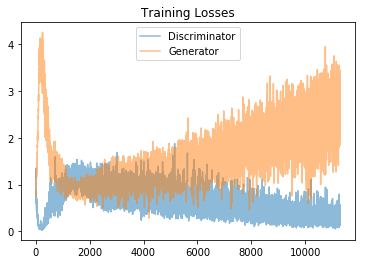

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

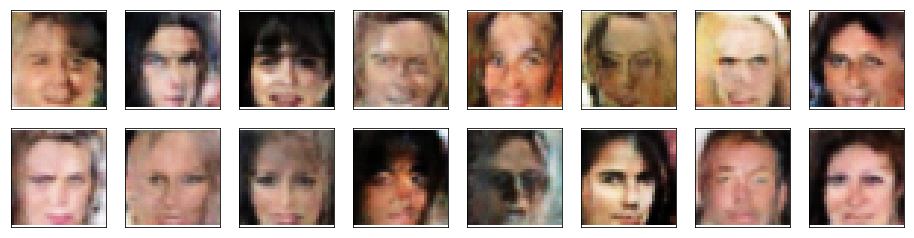

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** The three factors brought up bring up very good points to address to improve this model.
1. **The dataset is biased; it is made up of "celebrity" faces that are mostly white**  
While this model produces an image from a randomized vector it should be kept in mind the goal of the model. If the goal is to produce any face than the model has met its requirements. However, if the goal is to produce a certain kind of face (thin and dark or fat and light) from the random input, then the model would need an appropriate dataset from which to learn. Somewhat similar to describing color to a blind person, the model cannot infer certain features well if the trained model has never seen the feature in the dataset. Likewise, the bias in the model can be reduced by increasing the different types of faces the model sees.  

2. **Model size; larger models have the opportunity to learn more features in a data feature space**  
As mentioned above larger sets of data will allow the model to learn more features. Similar to how Europeans believed there were no black swans, but when black swans were discovered in Australia the truism had to be revised. An example would be people with eye patches. The model has never seen a photo of a person with an eye-patch so, the model will most likely never generate a face with an eye-patch. And if the generator did happen to make an individual with an eye-patch the discriminator would label the image as fake having never seen a person with an eye-patch.

3. **Optimization strategy; optimizers and number of epochs affect your final result**  
My first strategy was to adjust the learning rate looking at the respective losses for the generator and discriminator. As I reduced the learning rate the losses for the generator and discriminator got closer together. Interestingly, the losses for the generator decreased below those of the discriminator early on and then increased again.  
Once the learning rate did not seem as if it could be improved upon I adjusted the beta values to see how they would affect the behavior of the model.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

## Optimization tracking

### LR = 0.0002
beta1=0.2  
beta2=0.999 # default value  
n=20 # epochs  
batch_size=16  
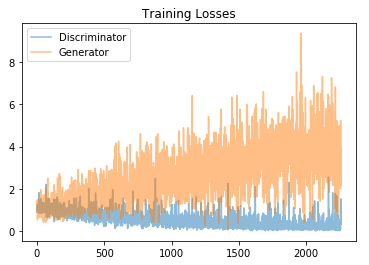
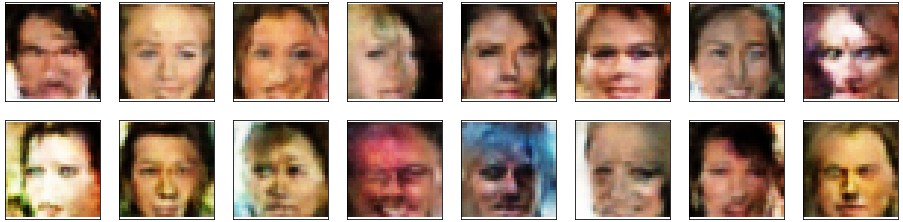

### LR = 0.00001
beta1=0.2  
beta2=0.999 # default value  
n=20 # epochs  
batch_size = 16  
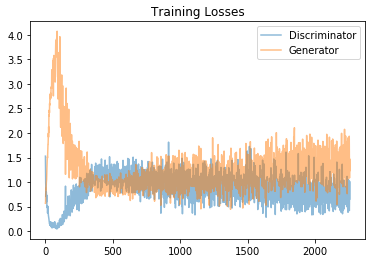
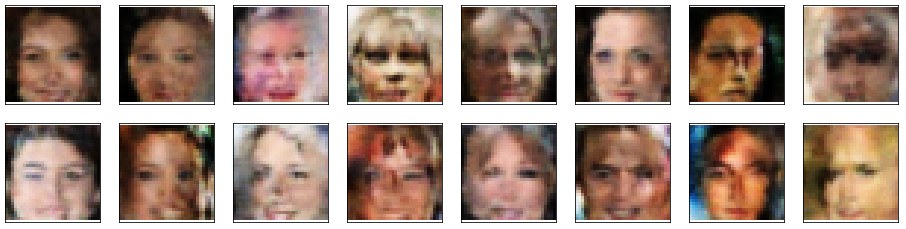

### LR = 0.000001
beta1=0.2  
beta2=0.999 # default value  
n=20 # epochs  
batch_size = 16  
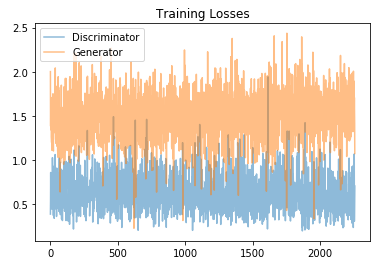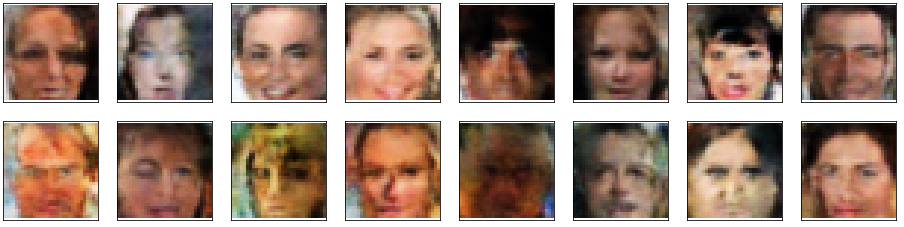

### lr = 0.000005
beta1=0.2  
beta2=0.999 # default value  
n=20 # epochs  
batch_size = 16  
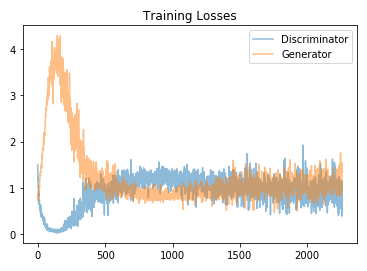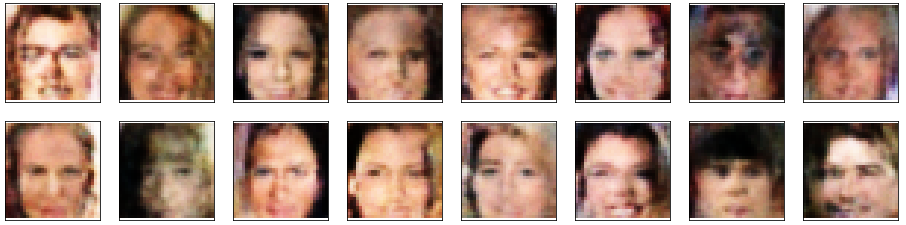

### lr = 0.000003  
beta1=0.2  
beta2=0.999 # default value  
n=20 # epochs  
batch_size = 16  
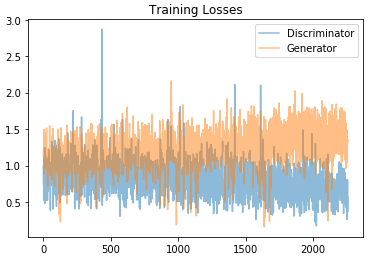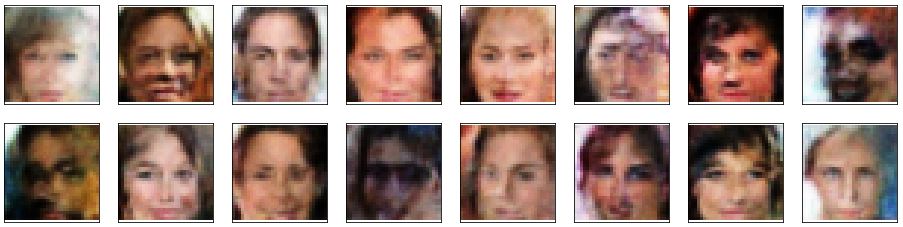

### lr = 0.000003
beta1=0.1  
beta2=0.999 # default value  
epochs=20  
batch_size=16
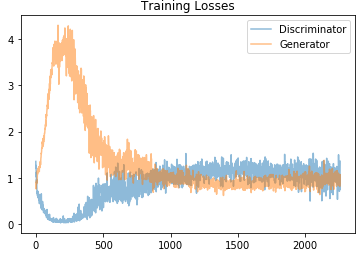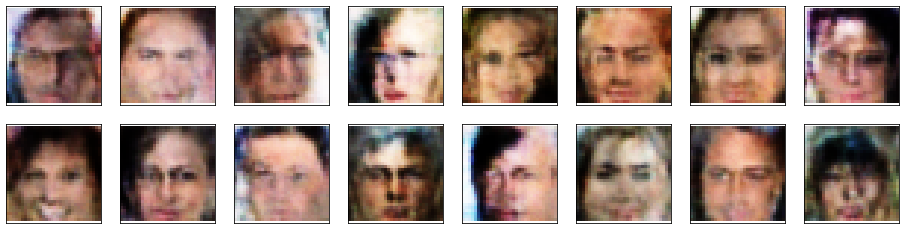

### lr = 0.000003
beta1=0.3  
beta2=0.999 # default value  
epochs = 20
batch_size = 16
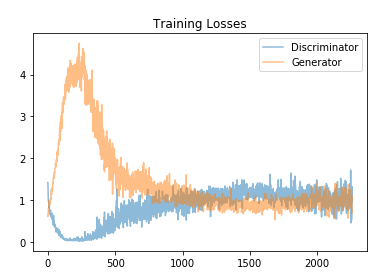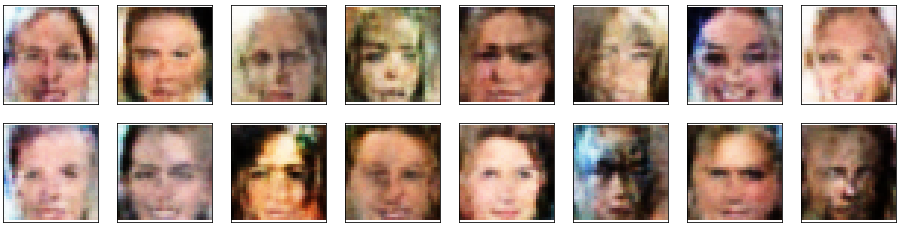

### lr = 0.000003
beta1=0.1  
beta2=0.9  
epochs=20  
batch_size= 16  
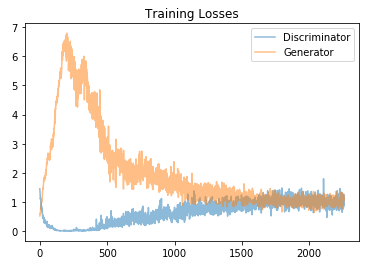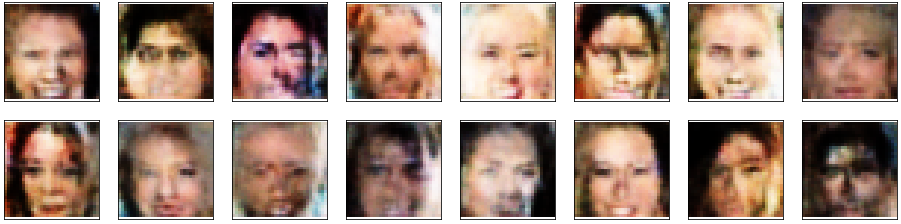

### lr = 0.000003
beta1=0.1  
beta2=0.9  
epochs=100  
batch_size= 16  
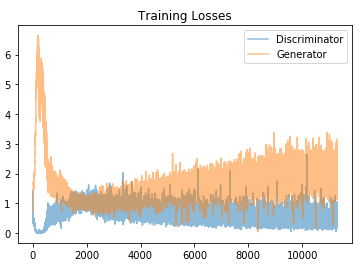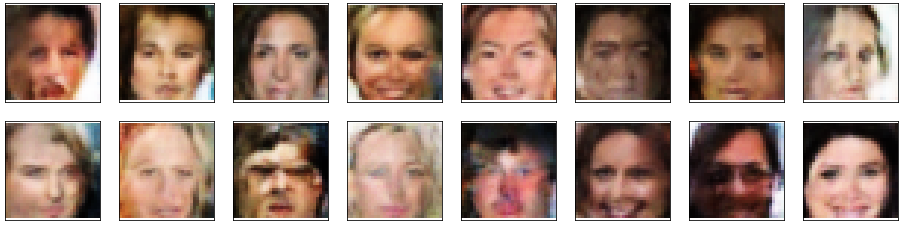

### lr = 0.000003
beta1=0.1  
beta2=0.999  
epochs=100  
batch_size= 16  
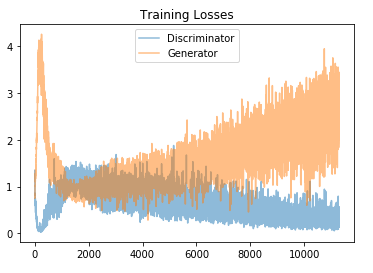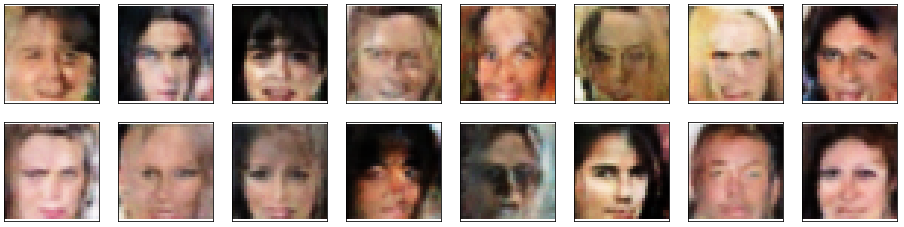